# 15. Reinforcement Learning
## CPE 490 590
## Rahul Bhadani


## 1. Markov Chain
![](https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/figures/MarkovChain.png)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

class MarkovChain:
    def __init__(self, transition_matrix, states):
        """
        Initialize the Markov chain with transition matrix and state names.
        
        Args:
            transition_matrix: 2D numpy array where [i,j] is the probability of transitioning from state i to state j
            states: List of state names
        """
        self.transition_matrix = np.array(transition_matrix)
        self.states = states
        self.n_states = len(states)
        
        # Validate that each row sums to 1 (valid probability distribution)
        row_sums = np.sum(self.transition_matrix, axis=1)
        if not np.allclose(row_sums, np.ones(self.n_states)):
            print("Warning: Transition matrix rows don't sum to 1")
            print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state_idx):
        """Generate the next state based on transition probabilities."""
        return np.random.choice(self.n_states, p=self.transition_matrix[current_state_idx])
    
    def generate_sequence(self, start_state_idx, length):
        """Generate a sequence of states starting from start_state."""
        current_state = start_state_idx
        sequence = [current_state]
        
        for _ in range(length-1):
            next_state_idx = self.next_state(current_state)
            sequence.append(next_state_idx)
            current_state = next_state_idx
            
        return sequence
    
# Define the transition matrix based on the diagram
# State 0: Dark blue
# State 1: Green
transition_matrix = np.array([
    [0.3, 0.7],  # From State 0: 0.3 probability to stay, 0.7 probability to go to State 1
    [0.9, 0.1]   # From State 1: 0.9 probability to go to State 0, 0.1 probability to stay
])

# Initialize the Markov chain
mc = MarkovChain(transition_matrix, states=["s0", "s1"])

# Example: Generate a sequence of 10 states starting from State 0
sequence = mc.generate_sequence(0, 10)
print("Generated sequence:", [mc.states[i] for i in sequence])


# Simulate the Markov chain for many steps to find steady state
def simulate_steady_state(mc, start_state=0, num_steps=100000):
    current = start_state
    state_counts = {i: 0 for i in range(mc.n_states)}
    
    for _ in range(num_steps):
        state_counts[current] += 1
        current = mc.next_state(current)
    
    # Convert counts to probabilities
    total = sum(state_counts.values())
    steady_state = {mc.states[i]: count/total for i, count in state_counts.items()}
    return steady_state

# Calculate steady state distribution
steady_state = simulate_steady_state(mc)
print("\nSteady state distribution (simulated):")
for state, prob in steady_state.items():
    print(f"State {state}: {prob:.4f}")

# Theoretical steady state calculation using linear algebra
def calculate_steady_state(transition_matrix):
    """Calculate the steady state distribution analytically."""
    # For a Markov chain with transition matrix P, the steady state π satisfies π = πP
    # This means π(P - I) = 0, plus we need the constraint that sum(π) = 1
    
    n = len(transition_matrix)
    A = np.vstack([np.transpose(transition_matrix) - np.eye(n), np.ones(n)])
    b = np.zeros(n+1)
    b[-1] = 1
    
    # Solve the system of equations
    try:
        steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
        return steady_state
    except np.linalg.LinAlgError:
        return None

# Calculate theoretical steady state
theoretical_steady_state = calculate_steady_state(transition_matrix)
if theoretical_steady_state is not None:
    print("\nTheoretical steady state distribution:")
    for i, prob in enumerate(theoretical_steady_state):
        print(f"State {mc.states[i]}: {prob:.4f}")

Generated sequence: ['s0', 's1', 's0', 's1', 's0', 's1', 's0', 's1', 's0', 's0']

Steady state distribution (simulated):
State s0: 0.5619
State s1: 0.4381

Theoretical steady state distribution:
State s0: 0.5625
State s1: 0.4375


## Example 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

class MarkovChain:
    def __init__(self, transition_matrix, states):
        """
        Initialize the Markov chain with transition matrix and state names.
        
        Args:
            transition_matrix: 2D numpy array where [i,j] is the probability of transitioning from state i to state j
            states: List of state names
        """
        self.transition_matrix = np.array(transition_matrix)
        self.states = states
        self.n_states = len(states)
        
        # Validate that each row sums to 1 (valid probability distribution)
        row_sums = np.sum(self.transition_matrix, axis=1)
        if not np.allclose(row_sums, np.ones(self.n_states)):
            print("Warning: Transition matrix rows don't sum to 1")
            print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state_idx):
        """Generate the next state based on transition probabilities."""
        return np.random.choice(self.n_states, p=self.transition_matrix[current_state_idx])
    
    def generate_sequence(self, start_state_idx, length):
        """Generate a sequence of states starting from start_state."""
        current_state = start_state_idx
        sequence = [current_state]
        
        for _ in range(length-1):
            next_state_idx = self.next_state(current_state)
            sequence.append(next_state_idx)
            current_state = next_state_idx
            
        return sequence
    
    def simulate_steady_state(self, start_state=0, num_steps=100000):
        """Simulate the Markov chain for many steps to find steady state."""
        current = start_state
        state_counts = {i: 0 for i in range(self.n_states)}
        
        for _ in range(num_steps):
            state_counts[current] += 1
            current = self.next_state(current)
        
        # Convert counts to probabilities
        total = sum(state_counts.values())
        steady_state = {self.states[i]: count/total for i, count in state_counts.items()}
        return steady_state

    def calculate_theoretical_steady_state(self):
        """Calculate the steady state distribution analytically."""
        # For a Markov chain with transition matrix P, the steady state π satisfies π = πP
        # This means π(P - I) = 0, plus we need the constraint that sum(π) = 1
        
        n = self.n_states
        A = np.vstack([np.transpose(self.transition_matrix) - np.eye(n), np.ones(n)])
        b = np.zeros(n+1)
        b[-1] = 1
        
        # Solve the system of equations
        try:
            steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
            return {self.states[i]: prob for i, prob in enumerate(steady_state)}
        except np.linalg.LinAlgError:
            return None

# Define the transition matrix for an autonomous vehicle's driving modes
# State 0: Normal driving
# State 1: Cautious driving (e.g., in poor weather or heavy traffic)
# State 2: Emergency handling (e.g., obstacle avoidance)
transition_matrix = np.array([
    [0.6, 0.3, 0.1],  # From Normal: 0.6 stay normal, 0.3 to cautious, 0.1 to emergency
    [0.4, 0.5, 0.1],  # From Cautious: 0.4 to normal, 0.5 stay cautious, 0.1 to emergency
    [0.1, 0.7, 0.2]   # From Emergency: 0.1 to normal, 0.7 to cautious, 0.2 stay in emergency
])

# Initialize the Markov chain
mc = MarkovChain(transition_matrix, states=["Normal", "Cautious", "Emergency"])

# Generate a sequence of 20 states starting from Normal driving
sequence = mc.generate_sequence(0, 20)
print("Driving mode sequence:")
for i, state_idx in enumerate(sequence):
    print(f"Time {i}: {mc.states[state_idx]}")

# Calculate simulated steady state distribution
simulated_steady = mc.simulate_steady_state(start_state=0)
print("\nSimulated steady state distribution:")
for state, prob in simulated_steady.items():
    print(f"State {state}: {prob:.4f}")

# Calculate theoretical steady state
theoretical_steady = mc.calculate_theoretical_steady_state()
if theoretical_steady:
    print("\nTheoretical steady state distribution:")
    for state, prob in theoretical_steady.items():
        print(f"State {state}: {prob:.4f}")

# Visualize state transitions over time
def visualize_transitions(sequence, states, title="State Transitions Over Time"):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sequence)), sequence, marker='o', linestyle='-')
    plt.yticks(range(len(states)), states)
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Simulate a longer sequence for visualization
long_sequence = mc.generate_sequence(0, 100)
# visualize_transitions(long_sequence, mc.states, "Autonomous Vehicle State Transitions")
# print("\nState transition visualization saved as 'av_state_transitions.png'")

# Example of how this Markov chain could be used in an autonomous vehicle decision system
def simulate_av_decisions(mc, start_state=0, n_steps=10):
    """Simulate autonomous vehicle decisions based on the Markov chain."""
    current_state = start_state
    decisions = []
    
    for step in range(n_steps):
        state_name = mc.states[current_state]
        
        # Make decision based on current state
        if state_name == "Normal":
            decision = "Maintain speed, standard spacing"
        elif state_name == "Cautious":
            decision = "Reduce speed by 20%, increase following distance"
        else:  # Emergency
            decision = "Execute emergency maneuver, maximum braking if needed"
            
        decisions.append(f"Step {step}: State = {state_name}, Action = {decision}")
        
        # Transition to next state
        current_state = mc.next_state(current_state)
    
    return decisions

# Simulate 5 decision steps
av_decisions = simulate_av_decisions(mc, start_state=0, n_steps=5)
print("\nSimulated AV decisions:")
for decision in av_decisions:
    print(decision)

Driving mode sequence:
Time 0: Normal
Time 1: Cautious
Time 2: Cautious
Time 3: Cautious
Time 4: Normal
Time 5: Cautious
Time 6: Cautious
Time 7: Cautious
Time 8: Cautious
Time 9: Cautious
Time 10: Normal
Time 11: Normal
Time 12: Normal
Time 13: Emergency
Time 14: Cautious
Time 15: Cautious
Time 16: Normal
Time 17: Normal
Time 18: Emergency
Time 19: Normal

Simulated steady state distribution:
State Normal: 0.4598
State Cautious: 0.4292
State Emergency: 0.1110

Theoretical steady state distribution:
State Normal: 0.4583
State Cautious: 0.4306
State Emergency: 0.1111

Simulated AV decisions:
Step 0: State = Normal, Action = Maintain speed, standard spacing
Step 1: State = Emergency, Action = Execute emergency maneuver, maximum braking if needed
Step 2: State = Cautious, Action = Reduce speed by 20%, increase following distance
Step 3: State = Normal, Action = Maintain speed, standard spacing
Step 4: State = Cautious, Action = Reduce speed by 20%, increase following distance


# 2. Markov Chain with Actions
![](https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/figures/MarkovChain_WithActions.png)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

class MarkovDecisionProcess:
    def __init__(self, transition_matrices, states, actions):
        """
        Initialize the Markov Decision Process with just states and actions.
        
        Args:
            transition_matrices: List of 2D numpy arrays, one for each action
                                where transition_matrices[a][i,j] is the probability 
                                of transitioning from state i to state j when taking action a
            states: List of state names
            actions: List of action names
        """
        self.transition_matrices = [np.array(tm) for tm in transition_matrices]
        self.states = states
        self.actions = actions
        self.n_states = len(states)
        self.n_actions = len(actions)
        
        # Validate transition matrices
        for a, tm in enumerate(self.transition_matrices):
            row_sums = np.sum(tm, axis=1)
            if not np.allclose(row_sums, np.ones(self.n_states)):
                print(f"Warning: Transition matrix for action {actions[a]} rows don't sum to 1")
                print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state, action):
        """Generate the next state based on current state and action."""
        return np.random.choice(self.n_states, p=self.transition_matrices[action][current_state])
    
    def generate_sequence(self, start_state, action_sequence):
        """
        Generate a sequence of states based on a starting state and sequence of actions.
        
        Args:
            start_state: Index of the starting state
            action_sequence: List of action indices to take
            
        Returns:
            List of states visited
        """
        current_state = start_state
        states_visited = [current_state]
        
        for action in action_sequence:
            current_state = self.next_state(current_state, action)
            states_visited.append(current_state)
            
        return states_visited
    
    def simulate_random_actions(self, start_state, length):
        """
        Simulate taking random actions for a specified length.
        
        Args:
            start_state: Index of the starting state
            length: Number of actions to take
            
        Returns:
            Tuple of (state_sequence, action_sequence)
        """
        current_state = start_state
        state_sequence = [current_state]
        action_sequence = []
        
        for _ in range(length):
            # Choose a random action
            action = random.randint(0, self.n_actions - 1)
            action_sequence.append(action)
            
            # Transition to next state based on the action
            current_state = self.next_state(current_state, action)
            state_sequence.append(current_state)
            
        return state_sequence, action_sequence
    
    def action_transition_probability(self, from_state, to_state):
        """
        Calculate the probability of transitioning from one state to another for each action.
        
        Args:
            from_state: Starting state index
            to_state: Ending state index
            
        Returns:
            Dictionary mapping action names to transition probabilities
        """
        probs = {}
        for a in range(self.n_actions):
            probs[self.actions[a]] = self.transition_matrices[a][from_state, to_state]
        return probs


# Define actions for our MDP
actions = ["stay_cautious", "explore_aggressively"]

# Define transition matrices for each action
# For stay_cautious:
transition_matrix0 = np.array([
    [0.3, 0.7],  # From State 0
    [0.9, 0.1]   # From State 1
])

# For explore_aggressively: different transition probabilities
transition_matrix1 = np.array([
    [0.8, 0.2],  # From State 0
    [0.4, 0.6]   # From State 1
])

transition_matrices = [transition_matrix0, transition_matrix1]

# Initialize the MDP
mdp = MarkovDecisionProcess(transition_matrices, states=["s0", "s1"], actions=actions)

# Example: Generate a sequence with a specific action sequence
action_sequence = [0, 1, 0, 1, 1]  # Alternate between actions
state_sequence = mdp.generate_sequence(0, action_sequence)
print("\nState sequence with predefined actions:")
for i, state in enumerate(state_sequence):
    if i < len(action_sequence):
        print(f"At state {mdp.states[state]}, took action {mdp.actions[action_sequence[i]]}")
    else:
        print(f"Ended at state {mdp.states[state]}")

# Simulate random actions
random_states, random_actions = mdp.simulate_random_actions(0, 10)
print("\nSimulation with random actions:")
for i in range(len(random_actions)):
    print(f"At state {mdp.states[random_states[i]]}, took action {mdp.actions[random_actions[i]]} → state {mdp.states[random_states[i+1]]}")

# Show transition probabilities for each action
print("\nTransition probabilities for each action:")
for s1 in range(mdp.n_states):
    for s2 in range(mdp.n_states):
        probs = mdp.action_transition_probability(s1, s2)
        print(f"From {mdp.states[s1]} to {mdp.states[s2]}:")
        for action, prob in probs.items():
            print(f"  Action '{action}': {prob:.2f}")


State sequence with predefined actions:
At state s0, took action stay_cautious
At state s1, took action explore_aggressively
At state s1, took action stay_cautious
At state s0, took action explore_aggressively
At state s1, took action explore_aggressively
Ended at state s0

Simulation with random actions:
At state s0, took action explore_aggressively → state s0
At state s0, took action stay_cautious → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s0
At state s0, took action stay_cautious → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s1
At state s1, took action explore_aggressively → state s0

Transition probabilities for each action:
From s0 to s0:
  Action 'stay_cautious': 0.30
  Action 'explore_aggressively': 0.80
From s0 t

# 3. Markov Chain with Actions and (State-Action) Rewards

![](https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/figures/MarkovChain_WithActionsAndReward.png)

In [2]:
import numpy as np
from copy import deepcopy

class MarkovDecisionProcess:
    def __init__(self, transition_matrices, rewards, states, actions, gamma=0.9):
        """
        Initialize the Markov Decision Process.
        
        Args:
            transition_matrices: List of 2D numpy arrays, one for each action
                                where transition_matrices[a][i,j] is the probability 
                                of transitioning from state i to state j when taking action a
            rewards: 2D numpy array where rewards[s, a] is the reward for taking action a in state s
            states: List of state names
            actions: List of action names
            gamma: Discount factor for future rewards (between 0 and 1)
        """
        self.transition_matrices = [np.array(tm) for tm in transition_matrices]
        self.rewards = np.array(rewards)
        self.states = states
        self.actions = actions
        self.gamma = gamma
        self.n_states = len(states)
        self.n_actions = len(actions)
        
        # Validate transition matrices
        for a, tm in enumerate(self.transition_matrices):
            row_sums = np.sum(tm, axis=1)
            if not np.allclose(row_sums, np.ones(self.n_states)):
                print(f"Warning: Transition matrix for action {actions[a]} rows don't sum to 1")
                print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state, action):
        """Generate the next state based on current state and action."""
        return np.random.choice(self.n_states, p=self.transition_matrices[action][current_state])
    
    def simulate_random_actions(self, start_state, n_steps):
        """
        Simulate taking random actions for n_steps steps, starting from start_state.
        
        Args:
            start_state: Index of the starting state
            n_steps: Number of steps to simulate
            
        Returns:
            history: List of (state, action, reward, next_state) tuples
            total_reward: Sum of rewards
            discounted_reward: Sum of discounted rewards
        """
        current_state = start_state
        history = []
        total_reward = 0
        discounted_reward = 0
        
        for step in range(n_steps):
            # Choose a random action
            action = np.random.randint(0, self.n_actions)
            
            # Get reward for this state-action pair
            reward = self.rewards[current_state, action]
            
            # Calculate next state
            next_state = self.next_state(current_state, action)
            
            # Record state, action, reward, next_state
            history.append((
                self.states[current_state], 
                self.actions[action], 
                reward, 
                self.states[next_state]
            ))
            
            # Update rewards
            total_reward += reward
            discounted_reward += reward * (self.gamma ** step)
            
            # Move to next state
            current_state = next_state
            
        return history, total_reward, discounted_reward


# Define actions for our MDP
actions = ["action0", "action1"]

# Define transition matrices for each action
# For action0:
transition_matrix0 = np.array([
    [0.3, 0.7],  # From State 0
    [0.9, 0.1]   # From State 1
])

# For action1: different transition probabilities
transition_matrix1 = np.array([
    [0.8, 0.2],  # From State 0
    [0.4, 0.6]   # From State 1
])

transition_matrices = [transition_matrix0, transition_matrix1]

# Define rewards - rewards[s, a] is reward for taking action a in state s
rewards = np.array([
    [1, 0],  # Rewards for state 0: action0 gives 1, action1 gives 0
    [0, 2]   # Rewards for state 1: action0 gives 0, action1 gives 2
])

# Initialize the MDP
mdp = MarkovDecisionProcess(transition_matrices, rewards, states=["s0", "s1"], actions=actions)

# Run multiple simulations
n_simulations = 5
n_steps = 10

print(f"Running {n_simulations} simulations with {n_steps} steps each...\n")

for sim in range(n_simulations):
    print(f"Simulation {sim + 1}:")
    
    # Start from random state
    start_state = np.random.randint(0, mdp.n_states)
    print(f"Starting state: {mdp.states[start_state]}")
    
    # Run simulation
    history, total_reward, discounted_reward = mdp.simulate_random_actions(start_state, n_steps)
    
    # Print results
    print("Step | State | Action | Reward | Next State")
    print("-" * 45)
    for i, (state, action, reward, next_state) in enumerate(history):
        print(f"{i+1:4d} | {state:5s} | {action:7s} | {reward:6.1f} | {next_state:5s}")
    
    print(f"\nTotal reward: {total_reward}")
    print(f"Discounted reward (gamma={mdp.gamma}): {discounted_reward:.4f}")
    print("-" * 50)

Running 5 simulations with 10 steps each...

Simulation 1:
Starting state: s0
Step | State | Action | Reward | Next State
---------------------------------------------
   1 | s0    | action1 |    0.0 | s1   
   2 | s1    | action0 |    0.0 | s0   
   3 | s0    | action1 |    0.0 | s1   
   4 | s1    | action0 |    0.0 | s0   
   5 | s0    | action0 |    1.0 | s0   
   6 | s0    | action1 |    0.0 | s0   
   7 | s0    | action0 |    1.0 | s0   
   8 | s0    | action0 |    1.0 | s0   
   9 | s0    | action0 |    1.0 | s1   
  10 | s1    | action0 |    0.0 | s0   

Total reward: 4
Discounted reward (gamma=0.9): 2.0963
--------------------------------------------------
Simulation 2:
Starting state: s0
Step | State | Action | Reward | Next State
---------------------------------------------
   1 | s0    | action1 |    0.0 | s0   
   2 | s0    | action1 |    0.0 | s1   
   3 | s1    | action0 |    0.0 | s1   
   4 | s1    | action0 |    0.0 | s0   
   5 | s0    | action0 |    1.0 | s1   
   

# 4. Optimizing Policy

In [2]:
import numpy as np
from copy import deepcopy

class MarkovDecisionProcess:
    def __init__(self, transition_matrices, rewards, states, actions, gamma=0.9):
        """
        Initialize the Markov Decision Process.
        
        Args:
            transition_matrices: List of 2D numpy arrays, one for each action
                                where transition_matrices[a][i,j] is the probability 
                                of transitioning from state i to state j when taking action a
            rewards: 2D numpy array where rewards[s, a] is the reward for taking action a in state s
            states: List of state names
            actions: List of action names
            gamma: Discount factor for future rewards (between 0 and 1)
        """
        self.transition_matrices = [np.array(tm) for tm in transition_matrices]
        self.rewards = np.array(rewards)
        self.states = states
        self.actions = actions
        self.gamma = gamma
        self.n_states = len(states)
        self.n_actions = len(actions)
        
        # Validate transition matrices
        for a, tm in enumerate(self.transition_matrices):
            row_sums = np.sum(tm, axis=1)
            if not np.allclose(row_sums, np.ones(self.n_states)):
                print(f"Warning: Transition matrix for action {actions[a]} rows don't sum to 1")
                print(f"Row sums: {row_sums}")
    
    def next_state(self, current_state, action):
        """Generate the next state based on current state and action."""
        return np.random.choice(self.n_states, p=self.transition_matrices[action][current_state])
    
    def simulate_random_actions(self, start_state, n_steps):
        """
        Simulate taking random actions for n_steps steps, starting from start_state.
        
        Args:
            start_state: Index of the starting state
            n_steps: Number of steps to simulate
            
        Returns:
            history: List of (state, action, reward, next_state) tuples
            total_reward: Sum of rewards
            discounted_reward: Sum of discounted rewards
        """
        current_state = start_state
        history = []
        total_reward = 0
        discounted_reward = 0
        
        for step in range(n_steps):
            # Choose a random action
            action = np.random.randint(0, self.n_actions)
            
            # Get reward for this state-action pair
            reward = self.rewards[current_state, action]
            
            # Calculate next state
            next_state = self.next_state(current_state, action)
            
            # Record state, action, reward, next_state
            history.append((
                self.states[current_state], 
                self.actions[action], 
                reward, 
                self.states[next_state]
            ))
            
            # Update rewards
            total_reward += reward
            discounted_reward += reward * (self.gamma ** step)
            
            # Move to next state
            current_state = next_state
            
        return history, total_reward, discounted_reward

    def value_iteration(self, theta=0.0001, max_iterations=1000):
        """
        Perform value iteration to find the optimal value function and policy.
        
        Args:
            theta: Convergence threshold
            max_iterations: Maximum number of iterations
            
        Returns:
            optimal_values: Optimal value function
            optimal_policy: Optimal policy (mapping from state to action)
        """
        # Initialize value function
        V = np.zeros(self.n_states)
        
        # Initialize policy
        policy = np.zeros(self.n_states, dtype=int)
        
        for i in range(max_iterations):
            delta = 0
            
            # For each state
            for s in range(self.n_states):
                v = V[s]
                
                # Compute the value of each action in this state
                action_values = []
                
                for a in range(self.n_actions):
                    # Expected value of taking action a in state s
                    expected_value = self.rewards[s, a]
                    
                    for s_next in range(self.n_states):
                        # Add expected future rewards
                        expected_value += self.gamma * self.transition_matrices[a][s, s_next] * V[s_next]
                    
                    action_values.append(expected_value)
                
                # Select the action with the highest expected value
                best_action = np.argmax(action_values)
                best_value = action_values[best_action]
                
                # Update policy and value function
                policy[s] = best_action
                V[s] = best_value
                
                # Check convergence
                delta = max(delta, abs(v - V[s]))
            
            if delta < theta:
                print(f"Value iteration converged after {i+1} iterations.")
                break
        
        # Convert policy from indices to action names
        policy_names = [self.actions[a] for a in policy]
        
        return V, policy_names
    
    def policy_iteration(self, max_iterations=1000, policy_eval_theta=0.0001):
        """
        Perform policy iteration to find the optimal policy.
        
        Args:
            max_iterations: Maximum number of iterations
            policy_eval_theta: Convergence threshold for policy evaluation
            
        Returns:
            optimal_values: Optimal value function
            optimal_policy: Optimal policy (mapping from state to action)
        """
        # Initialize random policy
        policy = np.random.randint(0, self.n_actions, size=self.n_states)
        
        for i in range(max_iterations):
            # Policy evaluation
            V = self._evaluate_policy(policy, theta=policy_eval_theta)
            
            # Policy improvement
            policy_stable = True
            
            for s in range(self.n_states):
                old_action = policy[s]
                
                # Compute the value of each action in this state
                action_values = []
                
                for a in range(self.n_actions):
                    # Expected value of taking action a in state s
                    expected_value = self.rewards[s, a]
                    
                    for s_next in range(self.n_states):
                        # Add expected future rewards
                        expected_value += self.gamma * self.transition_matrices[a][s, s_next] * V[s_next]
                    
                    action_values.append(expected_value)
                
                # Select the action with the highest expected value
                best_action = np.argmax(action_values)
                
                # Update policy
                policy[s] = best_action
                
                # Check if policy changed
                if old_action != best_action:
                    policy_stable = False
            
            if policy_stable:
                print(f"Policy iteration converged after {i+1} iterations.")
                break
        
        # Convert policy from indices to action names
        policy_names = [self.actions[a] for a in policy]
        
        return V, policy_names
    
    def _evaluate_policy(self, policy, theta=0.0001, max_iterations=1000):
        """
        Evaluate a policy by computing its value function.
        
        Args:
            policy: Policy to evaluate
            theta: Convergence threshold
            max_iterations: Maximum number of iterations
            
        Returns:
            V: Value function for the policy
        """
        # Initialize value function
        V = np.zeros(self.n_states)
        
        for i in range(max_iterations):
            delta = 0
            
            # For each state
            for s in range(self.n_states):
                v = V[s]
                
                # Get the action for this state under the current policy
                a = policy[s]
                
                # Compute new value
                V[s] = self.rewards[s, a]
                
                for s_next in range(self.n_states):
                    # Add expected future rewards
                    V[s] += self.gamma * self.transition_matrices[a][s, s_next] * V[s_next]
                
                # Check convergence
                delta = max(delta, abs(v - V[s]))
            
            if delta < theta:
                break
        
        return V
    
    def simulate_policy(self, policy, start_state, n_steps):
        """
        Simulate following a policy for n_steps steps, starting from start_state.
        
        Args:
            policy: Policy to follow (list of action indices)
            start_state: Index of the starting state
            n_steps: Number of steps to simulate
            
        Returns:
            history: List of (state, action, reward, next_state) tuples
            total_reward: Sum of rewards
            discounted_reward: Sum of discounted rewards
        """
        current_state = start_state
        history = []
        total_reward = 0
        discounted_reward = 0
        
        for step in range(n_steps):
            # Get action from policy
            if isinstance(policy[0], str):
                # If policy contains action names, convert to indices
                action = self.actions.index(policy[current_state])
            else:
                # If policy contains action indices
                action = policy[current_state]
            
            # Get reward for this state-action pair
            reward = self.rewards[current_state, action]
            
            # Calculate next state
            next_state = self.next_state(current_state, action)
            
            # Record state, action, reward, next_state
            history.append((
                self.states[current_state], 
                self.actions[action], 
                reward, 
                self.states[next_state]
            ))
            
            # Update rewards
            total_reward += reward
            discounted_reward += reward * (self.gamma ** step)
            
            # Move to next state
            current_state = next_state
            
        return history, total_reward, discounted_reward


# Example usage:

# Define actions for our MDP
actions = ["action0", "action1"]

# Define transition matrices for each action
# For action0:
transition_matrix0 = np.array([
    [0.3, 0.7],  # From State 0
    [0.9, 0.1]   # From State 1
])

# For action1: different transition probabilities
transition_matrix1 = np.array([
    [0.8, 0.2],  # From State 0
    [0.4, 0.6]   # From State 1
])

transition_matrices = [transition_matrix0, transition_matrix1]

# Define rewards - rewards[s, a] is reward for taking action a in state s
rewards = np.array([
    [1, 0],  # Rewards for state 0: action0 gives 1, action1 gives 0
    [0, 2]   # Rewards for state 1: action0 gives 0, action1 gives 2
])

# Initialize the MDP
mdp = MarkovDecisionProcess(transition_matrices, rewards, states=["s0", "s1"], actions=actions)

# Find optimal policy using value iteration
print("\n=== Value Iteration ===")
optimal_values_vi, optimal_policy_vi = mdp.value_iteration()
print(f"Optimal values: {optimal_values_vi}")
print(f"Optimal policy: {optimal_policy_vi}")

# Find optimal policy using policy iteration
print("\n=== Policy Iteration ===")
optimal_values_pi, optimal_policy_pi = mdp.policy_iteration()
print(f"Optimal values: {optimal_values_pi}")
print(f"Optimal policy: {optimal_policy_pi}")

# Simulate following the optimal policy
print("\n=== Simulating Optimal Policy ===")
start_state = 0
n_steps = 10
print(f"Starting state: {mdp.states[start_state]}")

history, total_reward, discounted_reward = mdp.simulate_policy(optimal_policy_vi, start_state, n_steps)

# Print results
print("Step | State | Action | Reward | Next State")
print("-" * 45)
for i, (state, action, reward, next_state) in enumerate(history):
    print(f"{i+1:4d} | {state:5s} | {action:7s} | {reward:6.1f} | {next_state:5s}")

print(f"\nTotal reward: {total_reward}")
print(f"Discounted reward (gamma={mdp.gamma}): {discounted_reward:.4f}")


=== Value Iteration ===
Value iteration converged after 73 iterations.
Optimal values: [15.77920351 16.69666484]
Optimal policy: ['action0', 'action1']

=== Policy Iteration ===
Policy iteration converged after 2 iterations.
Optimal values: [4.93351678 5.8151417 ]
Optimal policy: ['action0', 'action1']

=== Simulating Optimal Policy ===
Starting state: s0
Step | State | Action | Reward | Next State
---------------------------------------------
   1 | s0    | action0 |    1.0 | s0   
   2 | s0    | action0 |    1.0 | s0   
   3 | s0    | action0 |    1.0 | s1   
   4 | s1    | action1 |    2.0 | s1   
   5 | s1    | action1 |    2.0 | s0   
   6 | s0    | action0 |    1.0 | s1   
   7 | s1    | action1 |    2.0 | s1   
   8 | s1    | action1 |    2.0 | s1   
   9 | s1    | action1 |    2.0 | s0   
  10 | s0    | action0 |    1.0 | s1   

Total reward: 15
Discounted reward (gamma=0.9): 9.3385


## Example 2

Iteration 1:
Q(S0, Up) = 0.00
Q(S0, Down) = 0.00
Q(S0, Left) = 0.00
Q(S0, Right) = 0.00
Q(S1, Up) = 0.67
Q(S1, Down) = 8.00
Q(S1, Left) = 0.67
Q(S1, Right) = 0.67
Q(S2, Up) = 0.67
Q(S2, Down) = 0.67
Q(S2, Left) = 0.67
Q(S2, Right) = 8.00
Q(S3, Up) = 10.00
Q(S3, Down) = 10.00
Q(S3, Left) = 10.00
Q(S3, Right) = 10.00
Max change: 10.0000

Iteration 2:
Q(S0, Up) = 0.96
Q(S0, Down) = 6.24
Q(S0, Left) = 0.96
Q(S0, Right) = 6.24
Q(S1, Up) = 6.91
Q(S1, Down) = 8.96
Q(S1, Left) = 1.63
Q(S1, Right) = 6.91
Q(S2, Up) = 1.63
Q(S2, Down) = 6.91
Q(S2, Left) = 6.91
Q(S2, Right) = 8.96
Q(S3, Up) = 10.00
Q(S3, Down) = 10.00
Q(S3, Left) = 10.00
Q(S3, Right) = 10.00
Max change: 6.2400

Iteration 3:
Q(S0, Up) = 5.94
Q(S0, Down) = 7.74
Q(S0, Left) = 5.94
Q(S0, Right) = 7.74
Q(S1, Up) = 8.03
Q(S1, Down) = 9.45
Q(S1, Left) = 6.23
Q(S1, Right) = 8.03
Q(S2, Up) = 6.23
Q(S2, Down) = 8.03
Q(S2, Left) = 8.03
Q(S2, Right) = 9.45
Q(S3, Up) = 10.00
Q(S3, Down) = 10.00
Q(S3, Left) = 10.00
Q(S3, Right) = 10.00
Max chan

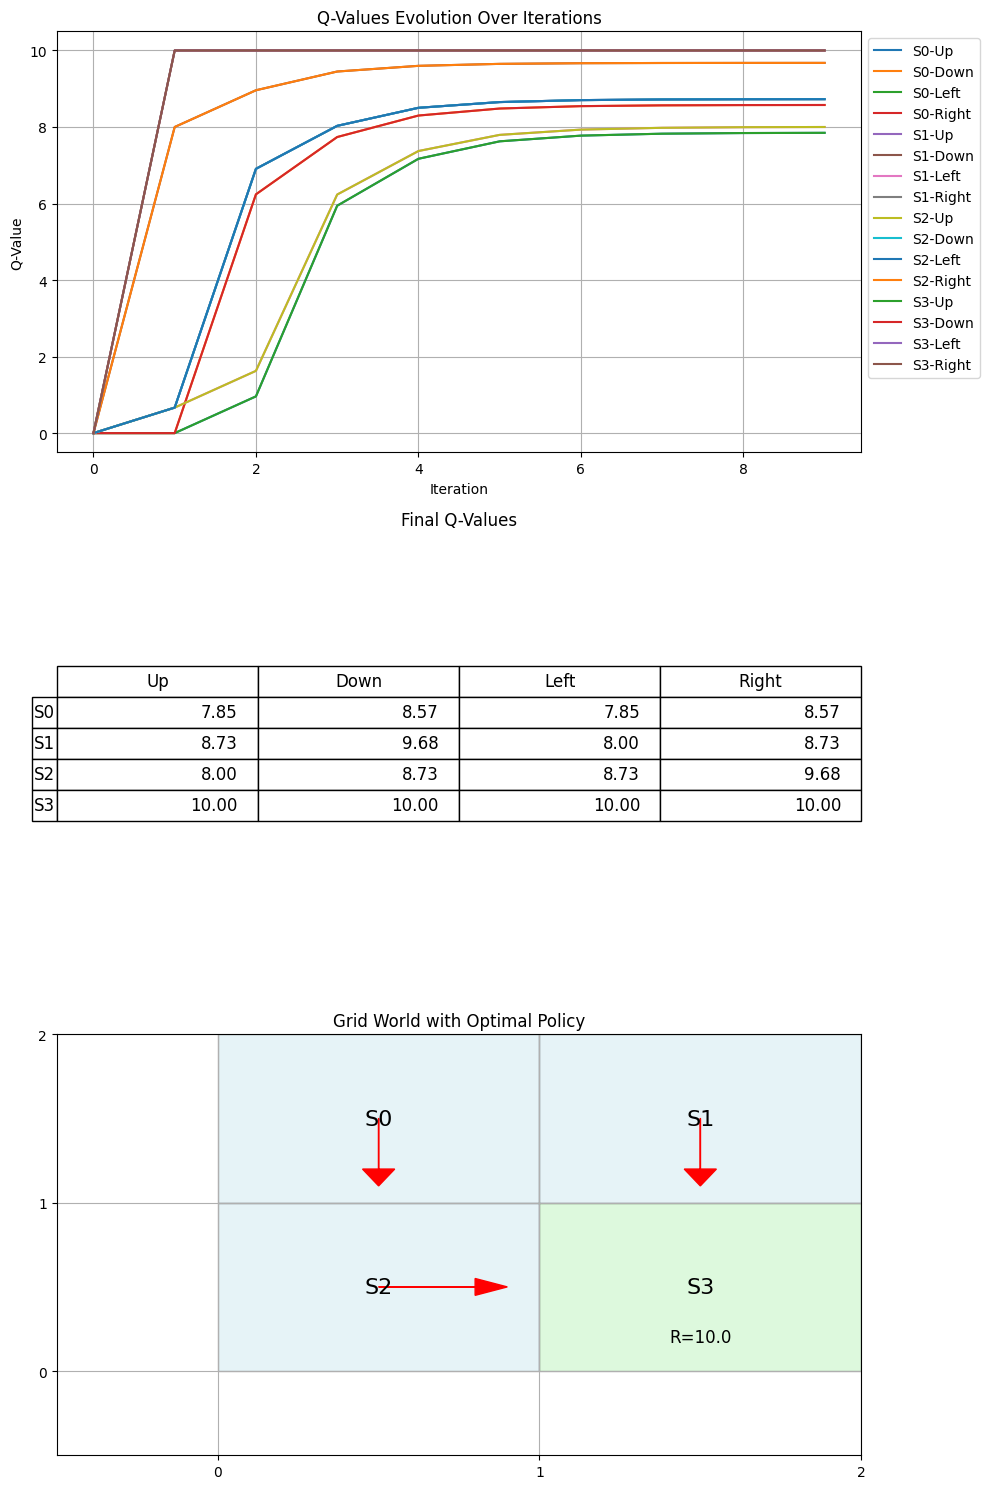

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.table import Table

# Define the grid world environment
# 0: S0, 1: S1, 2: S2, 3: S3 (terminal state with reward +10)
# Grid layout:
# 0 | 1
# ---+---
# 2 | 3

# Constants
NUM_STATES = 4
NUM_ACTIONS = 4  # 0: Up, 1: Down, 2: Left, 3: Right
TERMINAL_STATE = 3
GAMMA = 0.9      # Discount factor
SUCCESS_PROB = 0.8
FAIL_PROB = 0.2 / 3  # Distributed among other 3 actions
MAX_ITERATIONS = 20  # Number of value iterations

# Initialize Q-values
Q = np.zeros((NUM_STATES, NUM_ACTIONS))

# Initialize rewards
rewards = np.zeros(NUM_STATES)
rewards[TERMINAL_STATE] = 10  # Terminal state has reward of +10

# State transitions
# If action succeeds, where does the agent end up?
transitions = {
    # state 0 (top-left)
    (0, 0): 0,  # Up - hits wall, stays in place
    (0, 1): 2,  # Down - moves to state 2
    (0, 2): 0,  # Left - hits wall, stays in place
    (0, 3): 1,  # Right - moves to state 1
    
    # state 1 (top-right)
    (1, 0): 1,  # Up - hits wall, stays in place
    (1, 1): 3,  # Down - moves to state 3 (terminal)
    (1, 2): 0,  # Left - moves to state 0
    (1, 3): 1,  # Right - hits wall, stays in place
    
    # state 2 (bottom-left)
    (2, 0): 0,  # Up - moves to state 0
    (2, 1): 2,  # Down - hits wall, stays in place
    (2, 2): 2,  # Left - hits wall, stays in place
    (2, 3): 3,  # Right - moves to state 3 (terminal)
    
    # state 3 (bottom-right, terminal)
    (3, 0): 3,  # Terminal state - all actions keep agent in terminal state
    (3, 1): 3,
    (3, 2): 3,
    (3, 3): 3
}

# Simulating the Bellman update for a single state-action pair
def bellman_update(state, action):
    if state == TERMINAL_STATE:
        return rewards[state]  # Terminal state
    
    # Calculate expected value
    expected_value = 0
    
    # If action succeeds (with SUCCESS_PROB)
    next_state = transitions[(state, action)]
    immediate_reward = rewards[next_state]
    
    if next_state == TERMINAL_STATE:
        expected_value += SUCCESS_PROB * (immediate_reward)
    else:
        future_value = max(Q[next_state])
        expected_value += SUCCESS_PROB * (immediate_reward + GAMMA * future_value)
    
    # If action fails (with FAIL_PROB for each other action)
    other_actions = [a for a in range(NUM_ACTIONS) if a != action]
    for other_action in other_actions:
        next_state = transitions[(state, other_action)]
        immediate_reward = rewards[next_state]
        
        if next_state == TERMINAL_STATE:
            expected_value += FAIL_PROB * (immediate_reward)
        else:
            future_value = max(Q[next_state])
            expected_value += FAIL_PROB * (immediate_reward + GAMMA * future_value)
    
    return expected_value

# Store Q-values history for visualization
Q_history = [np.copy(Q)]

# Value iteration algorithm
for iteration in range(MAX_ITERATIONS):
    # Create a copy of Q for simultaneous update
    Q_new = np.zeros_like(Q)
    
    # Update Q-values for all state-action pairs
    for state in range(NUM_STATES):
        for action in range(NUM_ACTIONS):
            Q_new[state, action] = bellman_update(state, action)
    
    # Calculate maximum change in Q-values
    delta = np.max(np.abs(Q_new - Q))
    
    # Update Q-values
    Q = Q_new.copy()
    
    # Store Q-values for history
    Q_history.append(np.copy(Q))
    
    # Print iteration results
    print(f"Iteration {iteration+1}:")
    for state in range(NUM_STATES):
        for action in range(NUM_ACTIONS):
            print(f"Q(S{state}, {['Up', 'Down', 'Left', 'Right'][action]}) = {Q[state, action]:.2f}")
    print(f"Max change: {delta:.4f}")
    print()
    
    # Check for convergence
    if delta < 0.01:
        print(f"Converged after {iteration+1} iterations!")
        break

# Find optimal policy
optimal_policy = np.argmax(Q, axis=1)
policy_actions = ["Up", "Down", "Left", "Right"]

print("\nOptimal Policy:")
for state in range(NUM_STATES):
    print(f"State S{state}: {policy_actions[optimal_policy[state]]}")

# Visualize Q-values evolution
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot Q-values over iterations for each state-action pair
for state in range(NUM_STATES):
    ax[0].set_title('Q-Values Evolution Over Iterations')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Q-Value')
    
    for action in range(NUM_ACTIONS):
        values = [Q_hist[state, action] for Q_hist in Q_history]
        ax[0].plot(values, label=f'S{state}-{policy_actions[action]}')
        
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[0].grid(True)

# Visualize the final Q-values
action_names = ['Up', 'Down', 'Left', 'Right']
cell_text = []
for state in range(NUM_STATES):
    cell_text.append([f'{Q[state, action]:.2f}' for action in range(NUM_ACTIONS)])

table = ax[1].table(cellText=cell_text,
                  rowLabels=['S0', 'S1', 'S2', 'S3'],
                  colLabels=action_names,
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
ax[1].set_title('Final Q-Values')
ax[1].axis('off')

# Visualize the grid world with optimal policy
ax[2].set_title('Grid World with Optimal Policy')
ax[2].set_xlim(-0.5, 1.5)
ax[2].set_ylim(-0.5, 1.5)

# Draw grid
for i in range(2):
    for j in range(2):
        state = i * 2 + j
        color = 'lightgreen' if state == TERMINAL_STATE else 'lightblue'
        rect = patches.Rectangle((j, 1-i), 1, 1, linewidth=1, edgecolor='k', facecolor=color, alpha=0.3)
        ax[2].add_patch(rect)
        ax[2].text(j + 0.5, 1 - i + 0.5, f'S{state}', ha='center', va='center', fontsize=16)
        
        # Add reward text for terminal state
        if state == TERMINAL_STATE:
            ax[2].text(j + 0.5, 1 - i + 0.2, f'R={rewards[state]}', ha='center', va='center', fontsize=12)
        
        # Draw arrow for optimal policy
        if state != TERMINAL_STATE:
            action = optimal_policy[state]
            dx, dy = 0, 0
            if action == 0:  # Up
                dx, dy = 0, 0.3
            elif action == 1:  # Down
                dx, dy = 0, -0.3
            elif action == 2:  # Left
                dx, dy = -0.3, 0
            elif action == 3:  # Right
                dx, dy = 0.3, 0
            
            ax[2].arrow(j + 0.5, 1 - i + 0.5, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

ax[2].grid(True)
ax[2].set_xticks([0, 1, 2])
ax[2].set_yticks([0, 1, 2])

plt.tight_layout()
plt.show()

# 5. Grid World RL
## Rahul Bhadani

### Based on work by Eligijus Bujokas

The grid world problem is a classic problem in RL where we want to create an optimal strategy for an agent to traverse a grid.

No matter where our agent is, it can only move either left, right up or down. Now let us define and visualize our grid world:



In [ ]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches


In [ ]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

def plot_matrix(
    M: np.array,
    goal_coords: list = [],
    img_width: int = 5,
    img_height: int = 5,
    title: str = None,
    annotate_goal: bool = True
    ) -> None:
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')

    for y in range(height):
        for x in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
                if annotate_goal:
                    ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')
            else:
                ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.show()

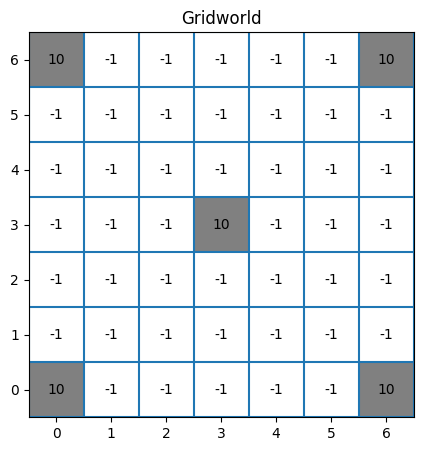

In [ ]:
# Importing the array library
import numpy as np

# Defining the number of blocks of a n x n grid
n = 7

# Defining the value for the hole and the goal
goal = 10
step = -1

# Initiating an empty dataframe of size n x n
R = np.ones((n,n))

# Defining the coordinates of the goal
goal_coords = [(0, n-1), (n-1, 0), (0, 0), (n-1, n-1), (n // 2, n // 2)]

# Adding the goal values to the center and the corners
for goal_coord in goal_coords:
    R[goal_coord[1], goal_coord[0]] = goal

# Every other step is -1
R[R == 1] = step

# Converting the G matrix to int
R = R.astype(int)

# Ploting
plot_matrix(R, goal_coords, title='Gridworld')

In the above example, we have defined our first needed matrix — the R matrix or the reward matrix. The goals are at the centre and at the corners of the grid world. When the agent goes into one of the cells, it receives a reward of the value of that cell.

# Let's define the state matrix

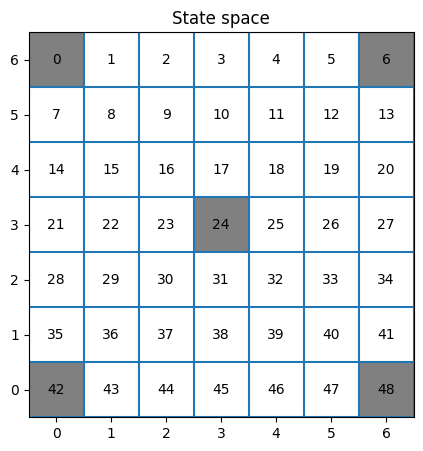

In [ ]:
S = np.arange(0, n*n).reshape(n, n)

plot_matrix(S, goal_coords, title='State space')

In the grid world that we defined, there are in total 49 states that an agent can be in. Each state can be identified by the integer from the matrix.



## Let us assume that our agent is in state 17 and moves down. What's the reward received (action value?

## If the agent is in state 17 and moves to the left, what's the reward received?

## Value function:


## $$ V^\pi (s) = \mathbb{E} \bigg[ \sum_{t\geq 0}^K \gamma^t r_t | s_0 = s, \pi \bigg] $$ where $K$ is the terminal state.

## Policy is $$ \pi (a, s)  = p \in [0, 1]$$ is the probability of taking an action  $a$ in state $s$

Let us initiate the initial value matrix V:



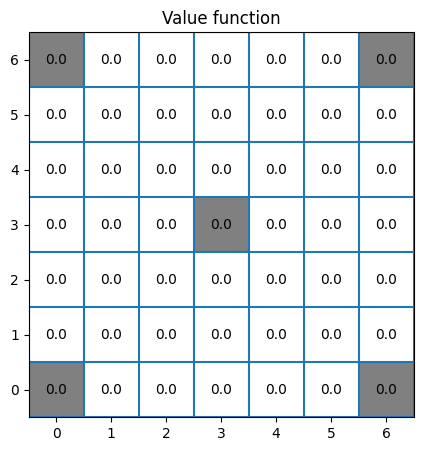

In [ ]:
# Initiating the empty Value function
V = np.zeros((n, n))

plot_matrix(V, goal_coords, title='Value function')

As we have not yet explored our created world of grids, all the returns of the states are 0.

The last matrix we will need is the policy matrix P.

In [ ]:
def plot_policy_matrix(P: dict, S:np.array, goal_coords: list = [], img_width: int = 5, img_height: int = 5, title: str = None) -> None:
    """
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows
    """
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for y in range(height):
        for x in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            else:
                # Adding the arrows to the plot
                if 'up' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                if 'down' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                if 'left' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                if 'right' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)


    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

# Saving all the unique states to a vector
states = np.unique(S)

# Dictionary to hold each action for a given state
P = {}
for s in states:
    s_dict = {}

    # Checking which index is the current state in the S matrix
    s_index = np.where(S == s)

    # If the state is in the top left corner, we can only move right and down
    if s_index == (0, 0):
        s_dict['right'] = 0.5
        s_dict['down'] = 0.5

    # If the state is in the top right corner, we can only move left and down
    elif s_index == (0, n - 1):
        s_dict['left'] = 0.5
        s_dict['down'] = 0.5

    # If the state is in the bottom left corner, we can only move right and up
    elif s_index == (n - 1, 0):
        s_dict['right'] = 0.5
        s_dict['up'] = 0.5

    # If the state is in the bottom right corner, we can only move left and up
    elif s_index == (n - 1, n - 1):
        s_dict['left'] = 0.5
        s_dict['up'] = 0.5

    # If the state is in the first row, we can only move left, right, and down
    elif s_index[0] == 0:
        s_dict['left'] = 0.333
        s_dict['right'] = 0.333
        s_dict['down'] = 0.333

    # If the state is in the last row, we can only move left, right, and up
    elif s_index[0] == n - 1:
        s_dict['left'] =  0.333
        s_dict['right'] = 0.333
        s_dict['up'] = 0.333

    # If the state is in the first column, we can only move up, down, and right
    elif s_index[1] == 0:
        s_dict['up'] = 0.333
        s_dict['down'] = 0.333
        s_dict['right'] = 0.333

    # If the state is in the last column, we can only move up, down, and left
    elif s_index[1] == n - 1:
        s_dict['up'] = 0.333
        s_dict['down'] = 0.333
        s_dict['left'] = 0.333

    # If the state is in the middle, we can move in all directions
    else:
        s_dict['up'] = 0.25
        s_dict['down'] = 0.25
        s_dict['left'] = 0.25
        s_dict['right'] = 0.25

    # Saving the current states trasition probabilities
    P[s] = s_dict

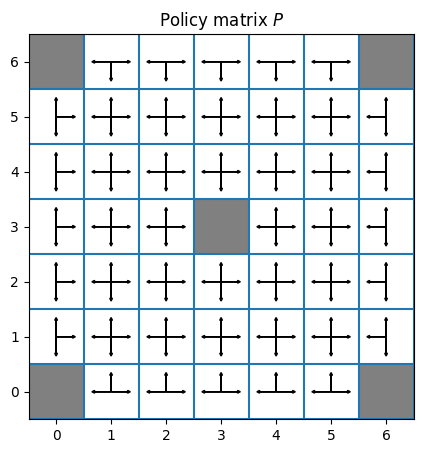

In [ ]:
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

Note tha the above one is not the optimal policy but all possible policy

## Having the R, P, S and V matrices, we can finally start calculating the answer for our RL problem. But we have yet to define, what is the RL objective.

### The objective of an RL algorithm is for the agent to find the optimal policy P that maximizes the returns in each state.



## Having the R, P, S and V matrices, we can finally start calculating the answer for our RL problem. But we have yet to define, what is the RL objective.

## The objective of an RL algorithm is for the agent to find the optimal policy P that maximizes the returns in each state.

## Another formulation is that the objective is to calculate the optimal state values in the matrix V.



## Recall that every value in the V matrix is the total accumulated discounted reward. Thus, our agent would want to always go to the state which has the highest value.

##  We can just list out all the available actions from the current state, check which available state has the highest $V(s)$ value and go there. Looking at the matrices above, we can see that, for example, state 8 has two optimal choices — down and left. This is because these actions will lead the agent into equally good states. Thus having the V matrix, we will always infer the P matrix.

# Value iteration for Grid World problem ca be written as

![image](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Oo1LPPdbyPUjwsc8INrt7g.png)

In [ ]:
def get_next_state(a: str, s: int, S: np.array):
    """
    Function that returns the next state's coordinates given an action and a state
    """
    # Getting the current indexes
    s_index = np.where(S == s)
    s_row = s_index[0][0]
    s_col = s_index[1][0]

    # Defining the indexes of the next state
    next_row = s_row
    next_col = s_col

    if a == 'up':
        next_row = s_row - 1
        next_col = s_col
    elif a == 'down':
        next_row = s_row + 1
        next_col = s_col
    elif a == 'left':
        next_row = s_row
        next_col = s_col - 1
    elif a == 'right':
        next_row = s_row
        next_col = s_col + 1

    return next_row, next_col

In [ ]:
def bellman_value(
    s: int,
    S: np.array,
    P: dict,
    G: np.array,
    V: np.array,
    gamma: float = 0.9
    ) -> Tuple:
    """
    Calculates the Belman equation value for the given state
    """
    # Extracting all the available actions for the given state
    actions = P[s]

    # Placeholder to hold the sum
    sum = 0
    for action in actions:
        # Extracting the probability of the given action
        prob = actions[action]

        # Getting the next states indexes
        next_row, next_col = get_next_state(action, s, S)

        # Extracting the expected reward
        reward = G[next_row, next_col]

        # Extracting the value of the next state
        value_prime = V[next_row, next_col]

        # Adding to the sum
        sum += prob * (reward + gamma * value_prime)

    return sum

In [ ]:
def get_max_return(s: int, S: np.array, P: dict, G: np.array, V: np.array, gamma: float = 0.9) -> Tuple:
    """
    Returns the best action and the Bellman's value for the given state
    """
    # Extracting all the available actions for the given state
    actions = P[s]

    # Placeholder to hold the best action and the max return
    best_action = None
    max_return = -np.inf

    for action in actions:
        # Getting the probability of the action
        prob = actions[action]

        # Getting the next states indexes
        next_row, next_col = get_next_state(action, s, S)

        # Extracting the expected reward
        reward = G[next_row, next_col]

        # Extracting the value of the next state
        value_prime = V[next_row, next_col]

        # Calculating the return
        _return = prob * (reward + gamma * value_prime)

        # Checking if the return is greater than the current max return
        if _return > max_return:
            best_action = action
            max_return = _return

    return best_action, max_return


In [ ]:
def update_value(s, S, P, G, V, gamma) -> float:
    """
    Updates the value function for the given state
    """
    # Getting the indexes of s in S
    s_index = np.where(S == s)
    s_row = s_index[0][0]
    s_col = s_index[1][0]

    # Getting the best action and the Bellman's value
    _, max_return = get_max_return(s, S, P, G, V, gamma)

    # Rounding up the bellman value
    max_return = np.round(max_return, 2)

    # Updating the value function with a rounded value
    V[s_row, s_col] = max_return

    return max_return


In [ ]:
def value_iteration(
    S: np.array,
    P: np.array,
    G: np.array,
    V: np.array,
    gamma: float = 0.9,
    epsilon: float = 0.0001,
    n_iter: int = None
    ) -> None:
    """
    Function that performs the value iteration algorithm

    The function updates the V matrix inplace
    """
    # Iteration tracker
    iteration = 0

    # Iterating until the difference between the value functions is less than epsilon
    iterate = True
    while iterate:
        # Placeholder for the maximum difference between the value functions
        delta = 0

        # Updating the iteration tracker
        iteration += 1
        # Iterating over the states
        for s in S.flatten():
            # Getting the indexes of s in S
            s_index = np.where(S == s)
            s_row = s_index[0][0]
            s_col = s_index[1][0]

            # Saving the current value for the state
            v_init = V[s_row, s_col].copy()

            # Updating the value function
            v_new = update_value(s, S, P, G, V, gamma)

            # Updating the delta
            delta = np.max([delta, np.abs(v_new - v_init)])

            if (delta < epsilon) and (n_iter is None):
                iterate = False
                break

        if (n_iter is not None) and (iteration >= n_iter):
            iterate = False

    # Printing the iteration tracker
    print(f"Converged in {iteration} iterations")

    return None

In [ ]:
def update_policy(S, P, V):
    """
    Function that updates the policy given the value function
    """
    # Iterating over the states
    for s in S.flatten():
        # Listing all the actions
        actions = P[s]

        # For each available action, getting the Bellman's value
        values = {}
        for action in actions.keys():
            # Getting the next state indexes
            next_row, next_col = get_next_state(action, s, S)

            # Saving the value function of that nex t state
            values[action] = V[next_row, next_col]

        # Extracting the maximum key value of the values dictionary
        max_value = max(values.values())

        # Leaving the keys that are equal to the maximum value
        best_actions = [key for key in values if values[key] == max_value]

        # Getting the length of the dictionary
        length = len(values)

        # Creating the final dictionary with all the best actions in it
        p_star = {}
        for action in best_actions:
            p_star[action] = 1/length

        # Updating the policy
        P[s] = p_star

## Now let us update one state - the first or $s = 1$.



In [ ]:
update_value(1, S, P, R, V, gamma=0.9)
update_policy(S, P, V)

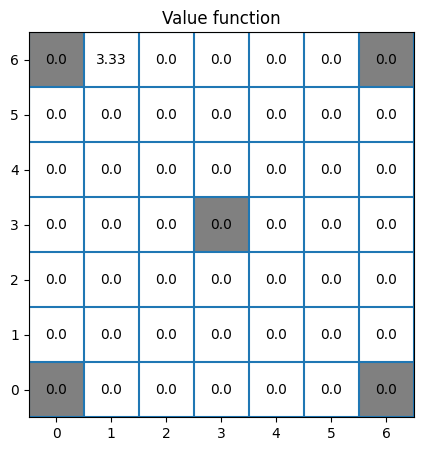

In [ ]:
plot_matrix(V, goal_coords, title='Value function')

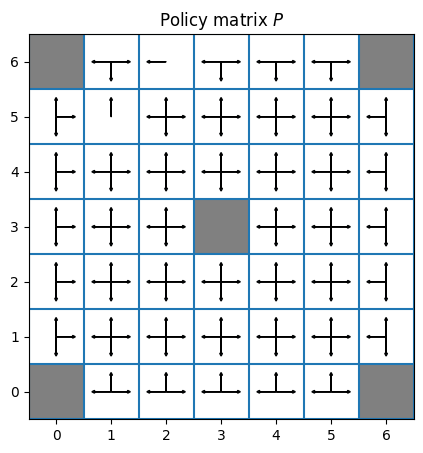

In [ ]:
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

## Let us now update state 3 and see what is happening:



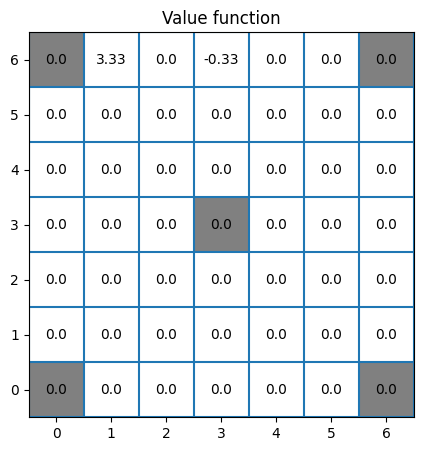

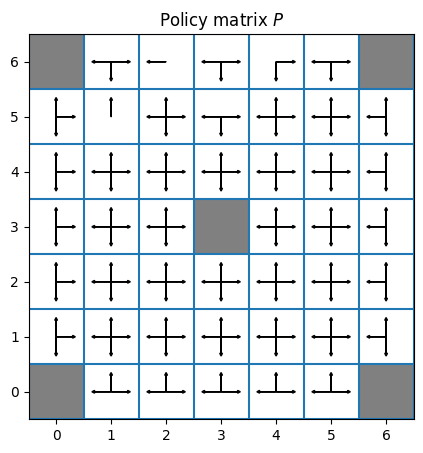

In [ ]:
update_value(3, S, P, R, V, gamma=0.9)
update_policy(S, P, V)
plot_matrix(V, goal_coords, title='Value function')
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')


## The value iteration algorithm works in the exact same fashion as above just for all the states (in our case — from states 0 to 48). To implement it use the following code:

In [ ]:
value_iteration(S, P, R, V, epsilon=10**-16)
update_policy(S, P, V)

Converged in 6 iterations


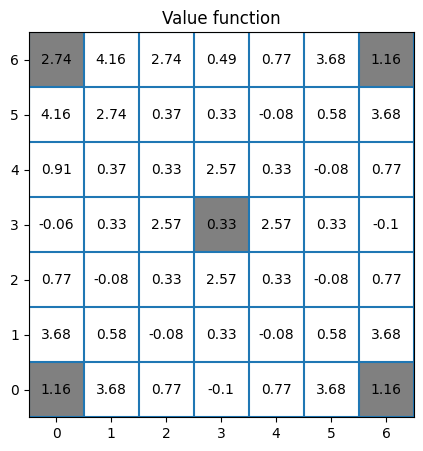

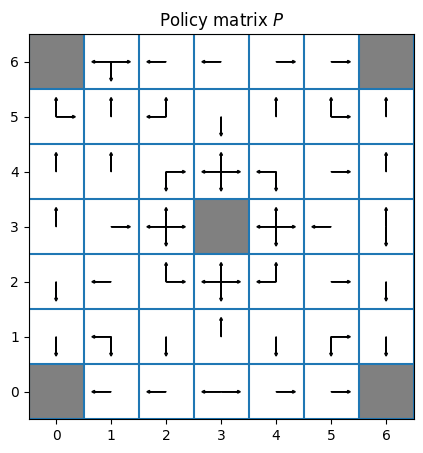

In [ ]:
plot_matrix(V, goal_coords, title='Value function')
plot_policy_matrix(P, S, goal_coords, title='Policy matrix $P$')

## The agent could start in any non-terminal state and move along the arrows in the policy matrix. If there are two or more arrows in the same state, we can move with the same probability into each of the states that the arrows are pointing to.

# 6. Deep Reinforcement Learning (Q-learning with Exprience Replay)

Training agent...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:07<00:00, 70.34it/s] 



Training results:


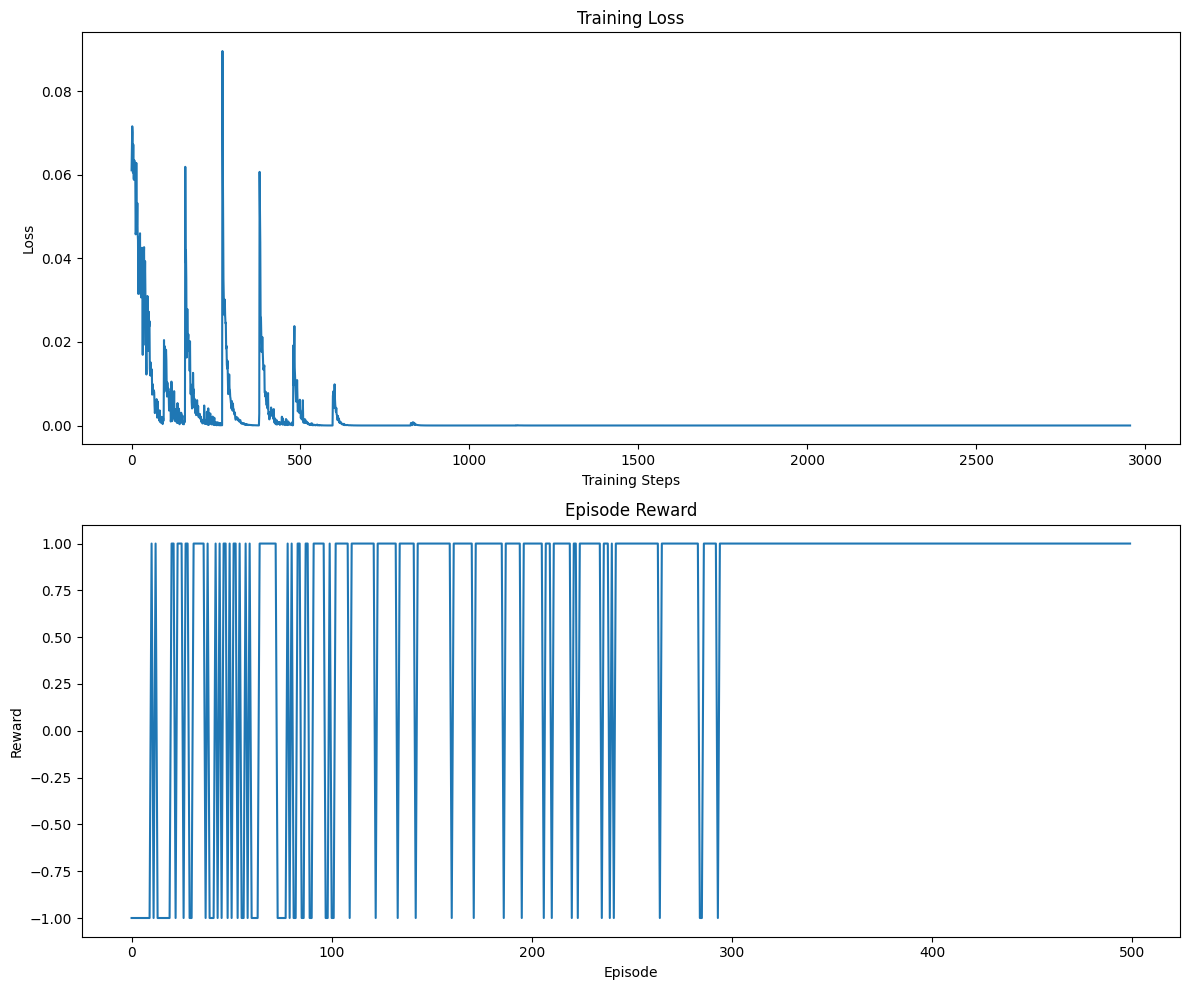


Q-values evolution:
Q-values after episode 0


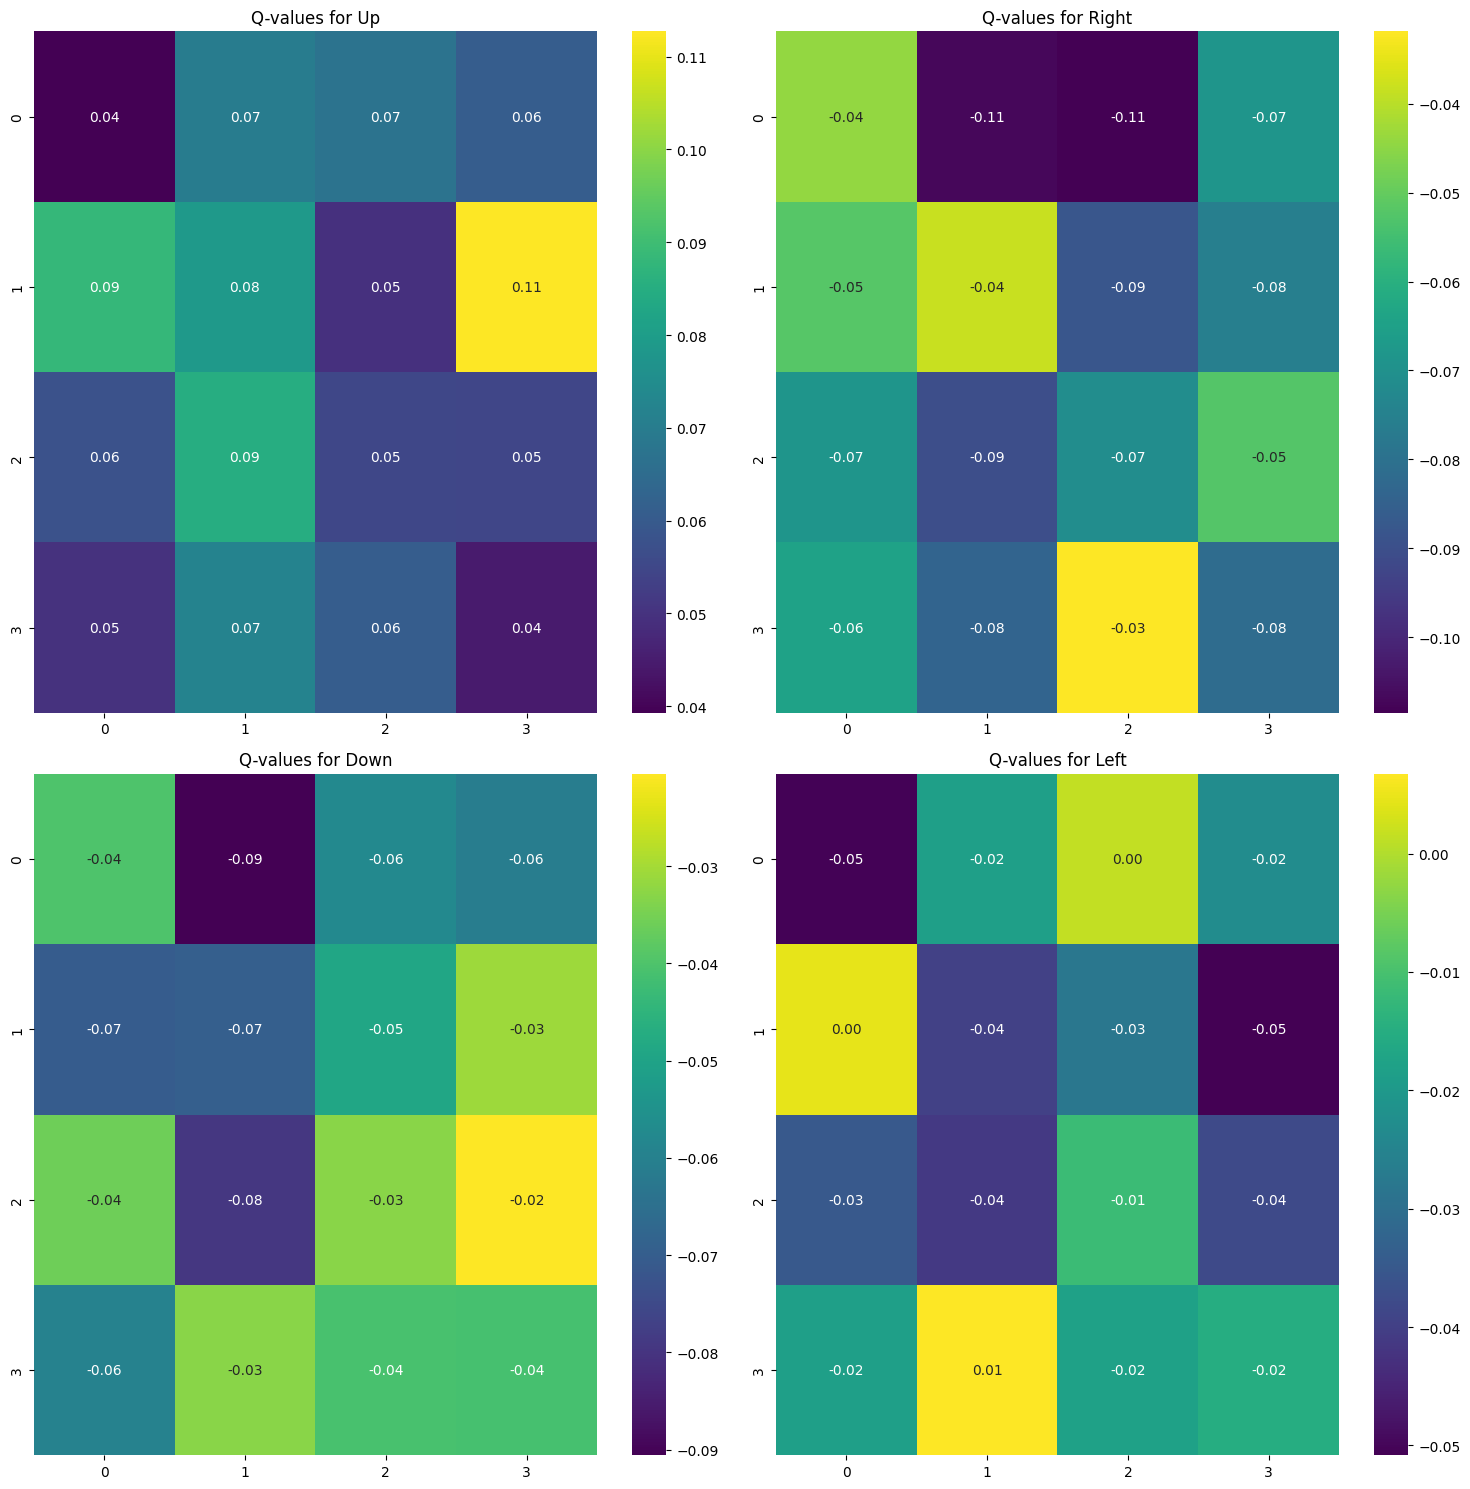

Q-values after episode 160


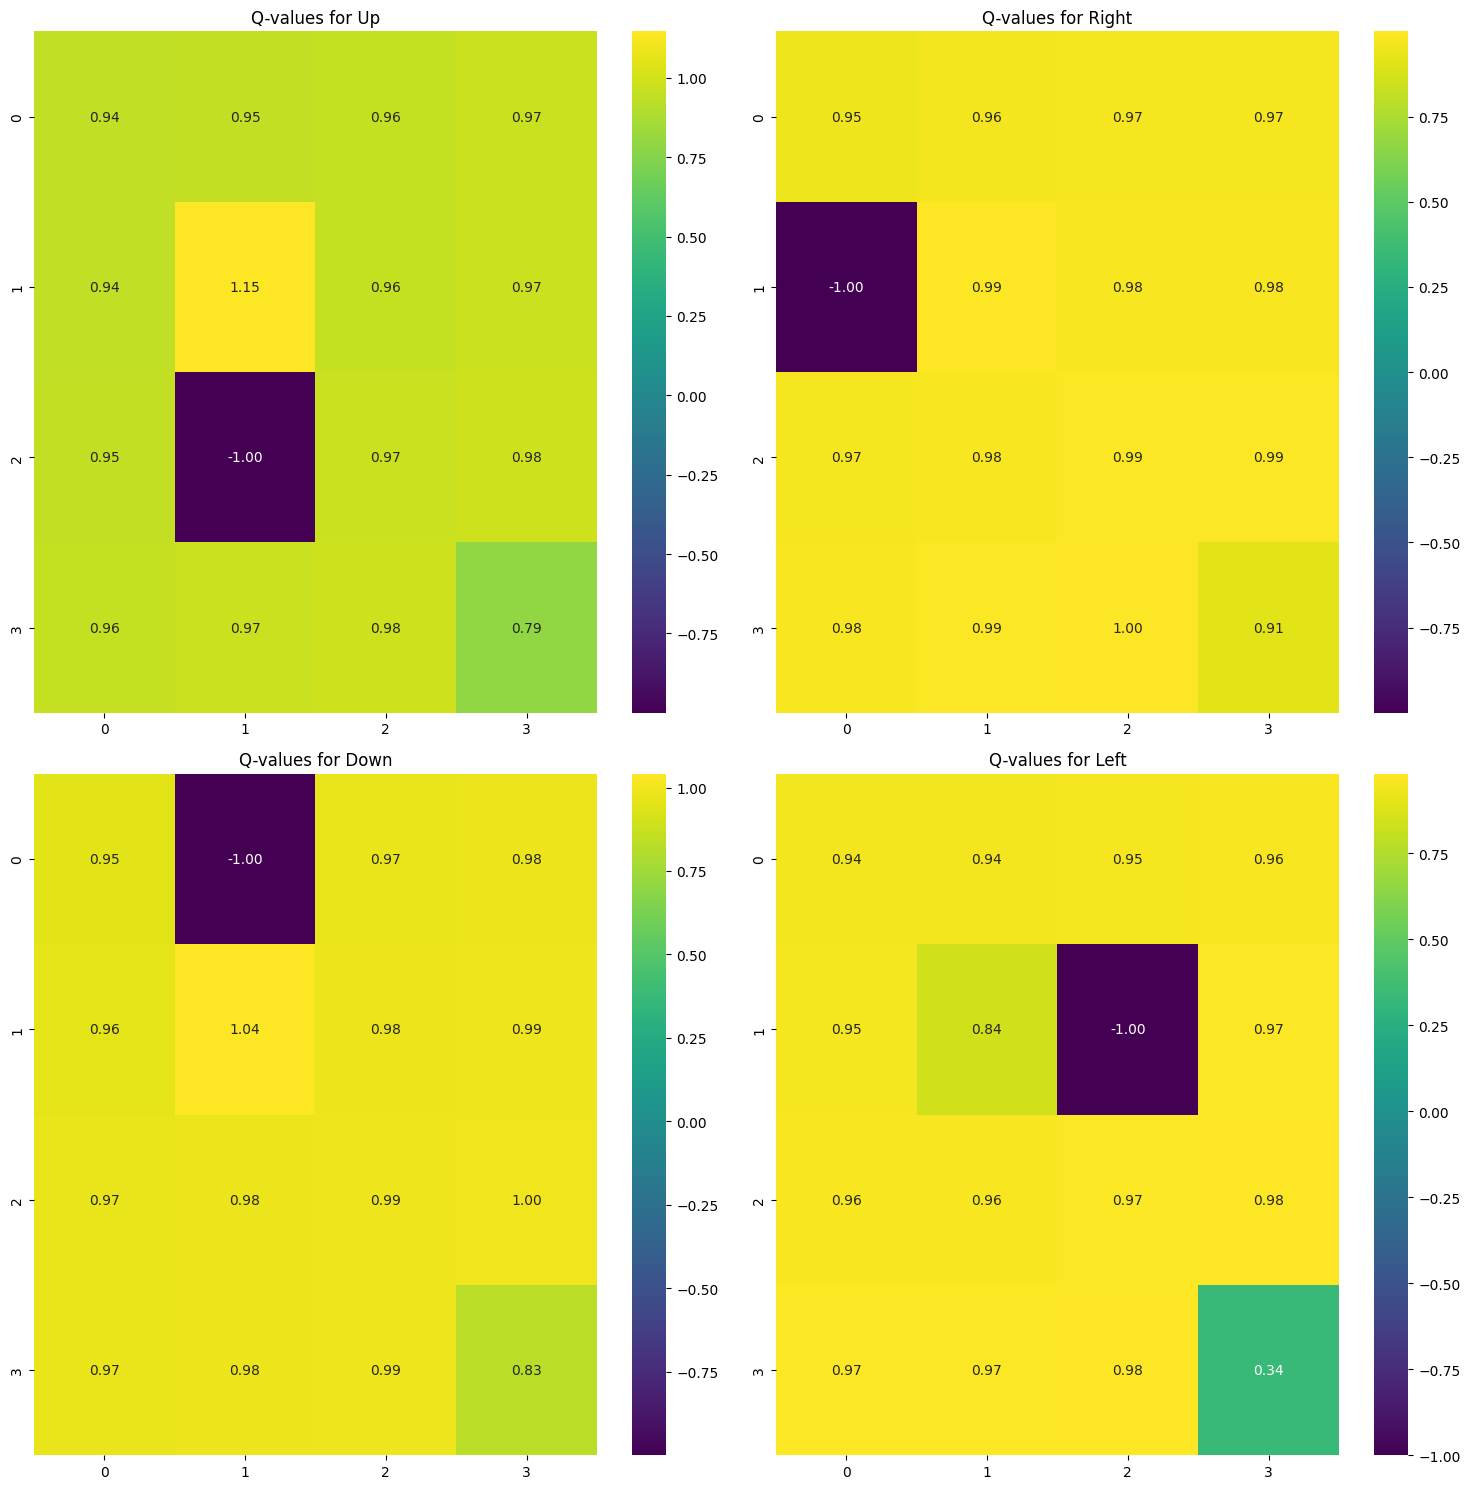

Q-values after episode 320


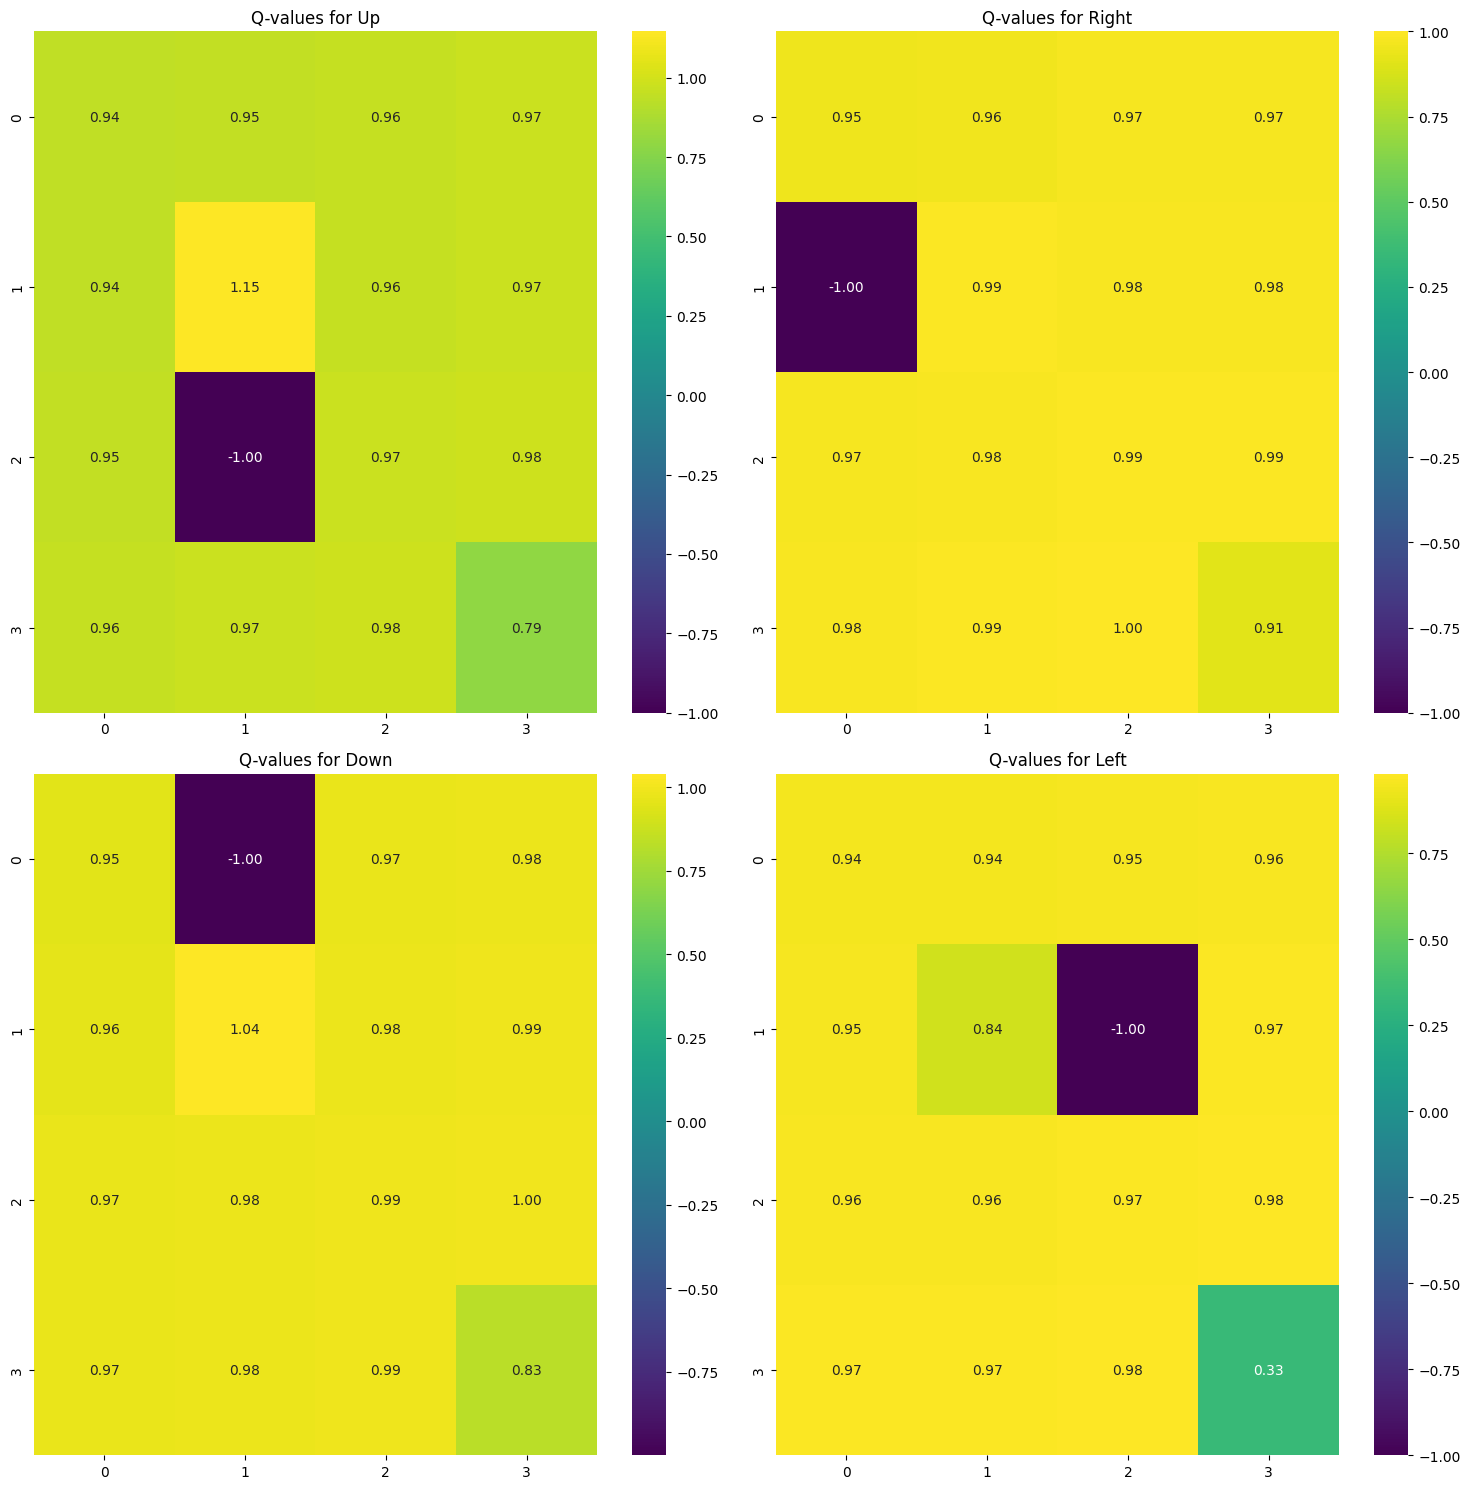

Q-values after episode 490


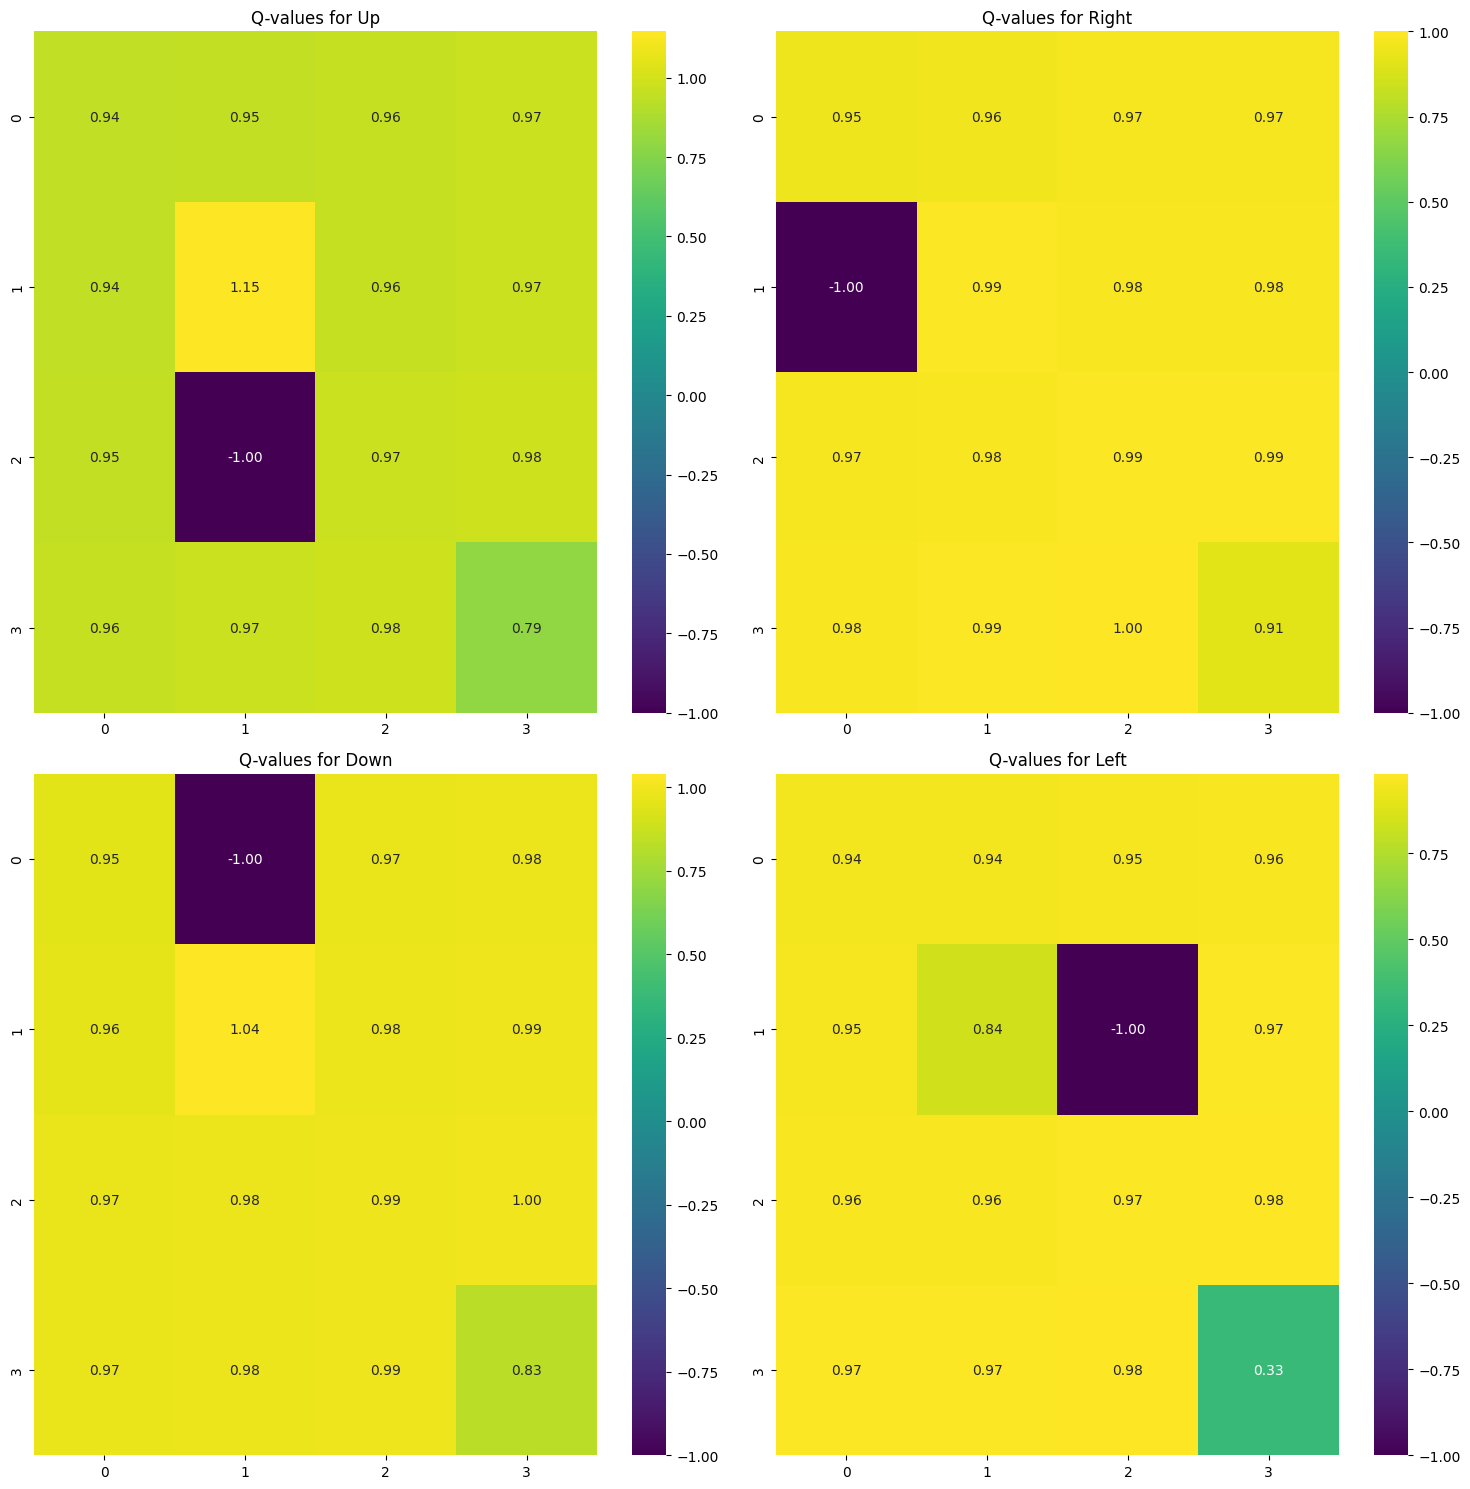


Final Q-values:


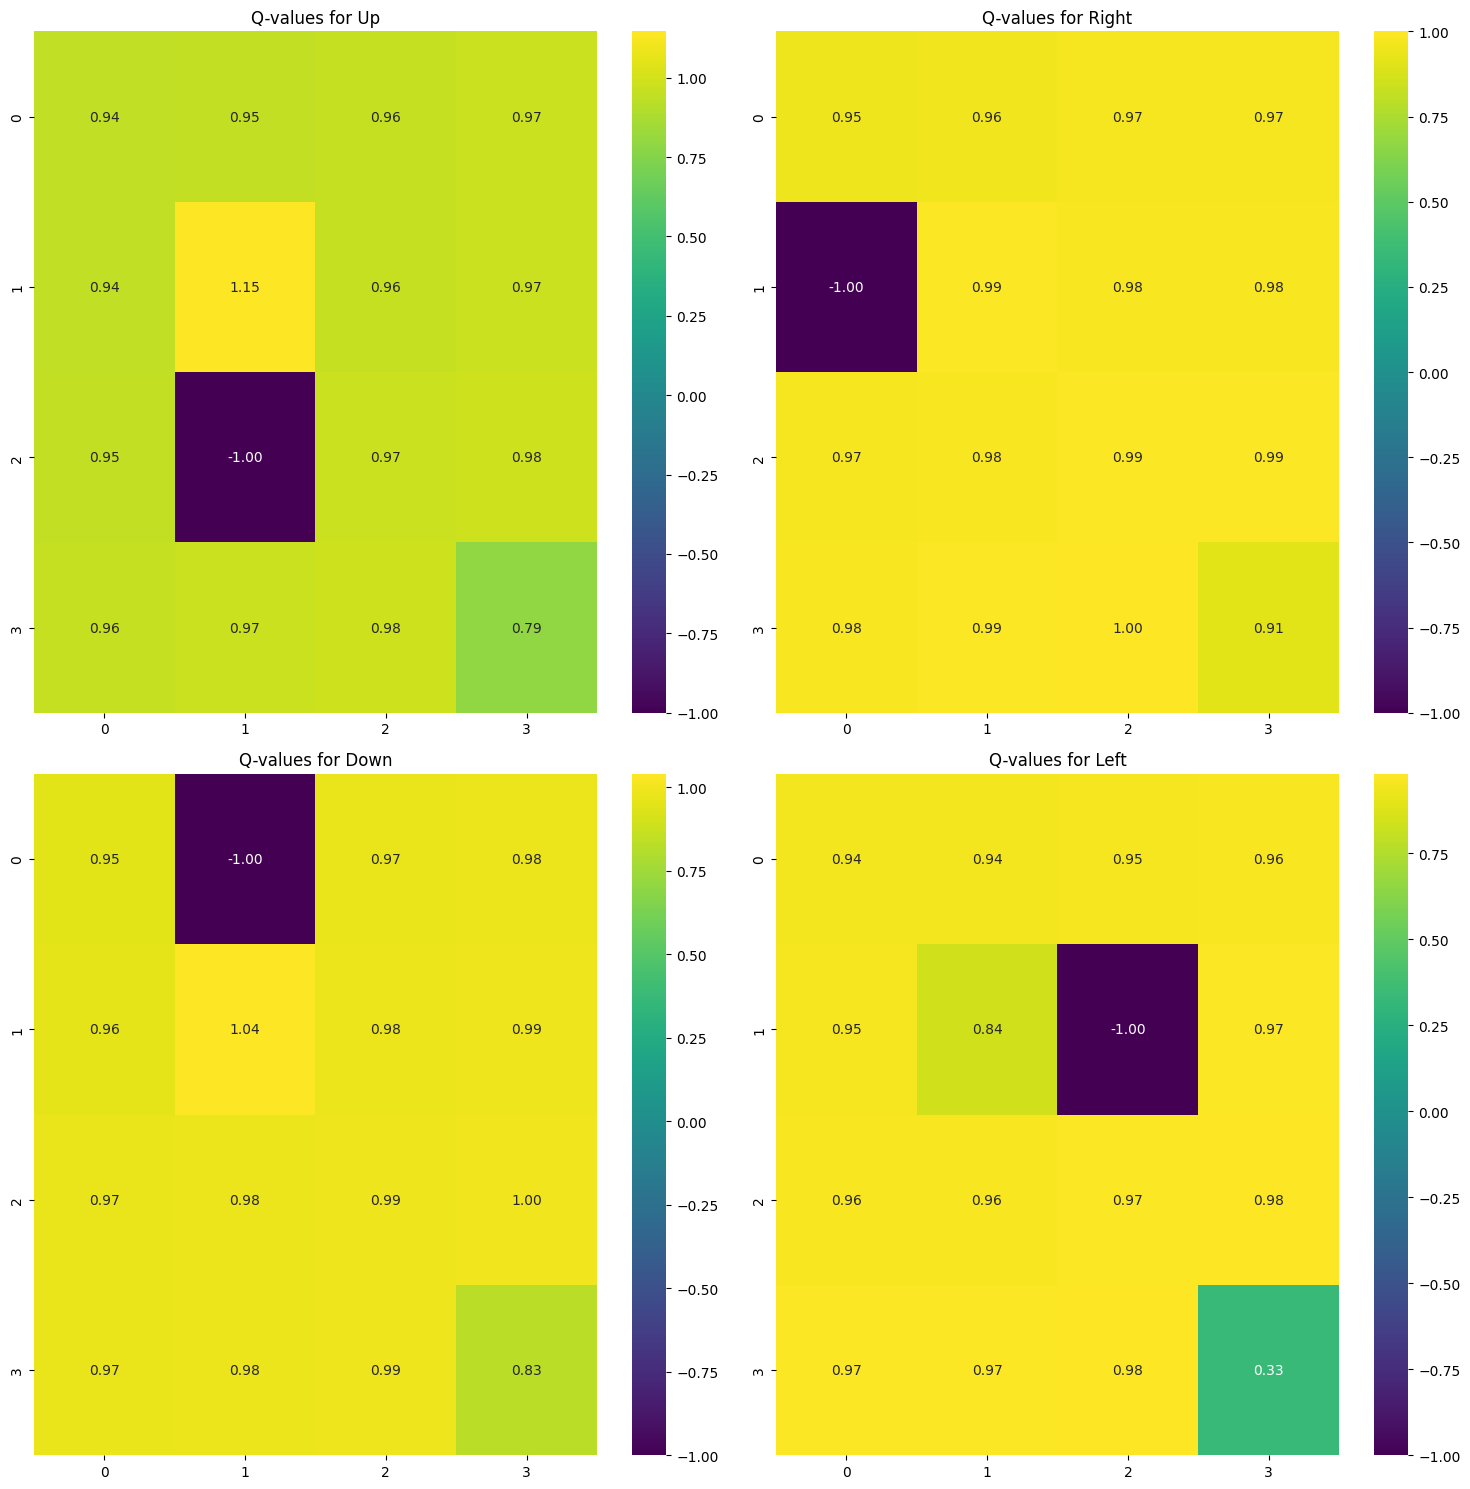


Optimal policy:


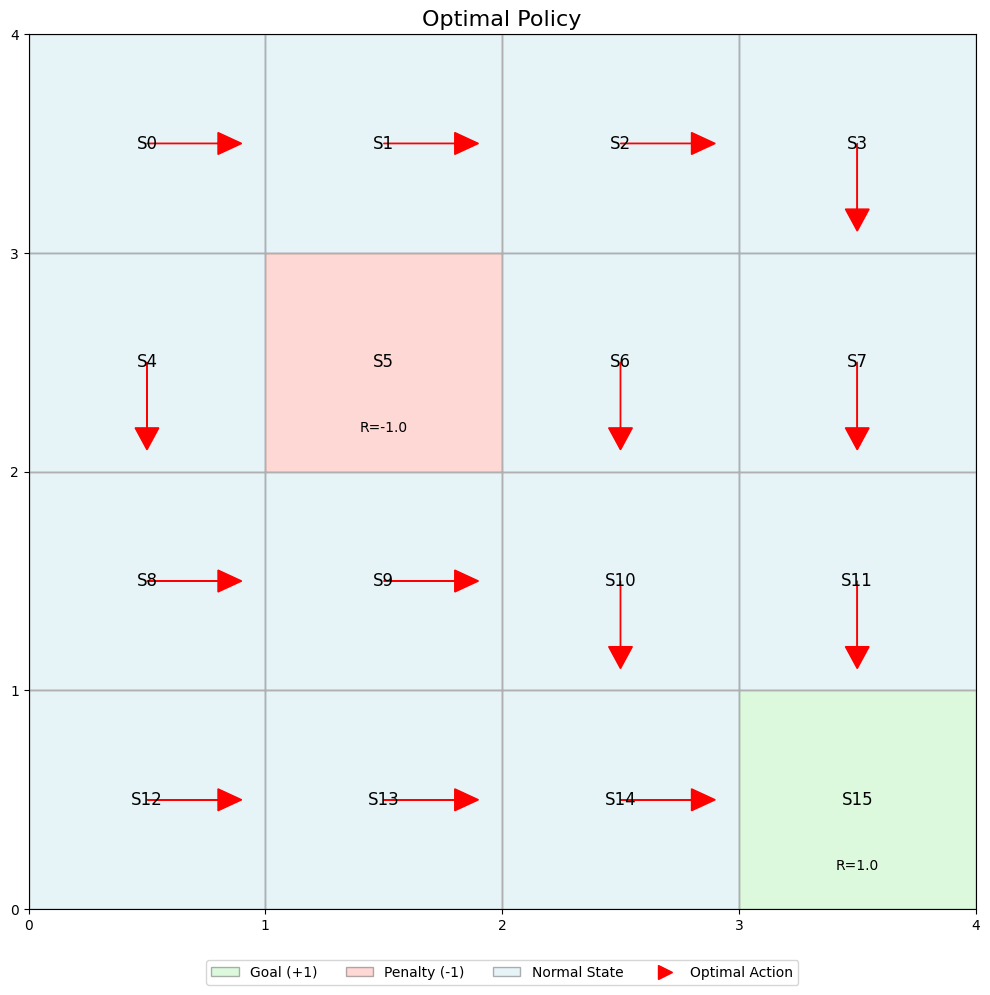

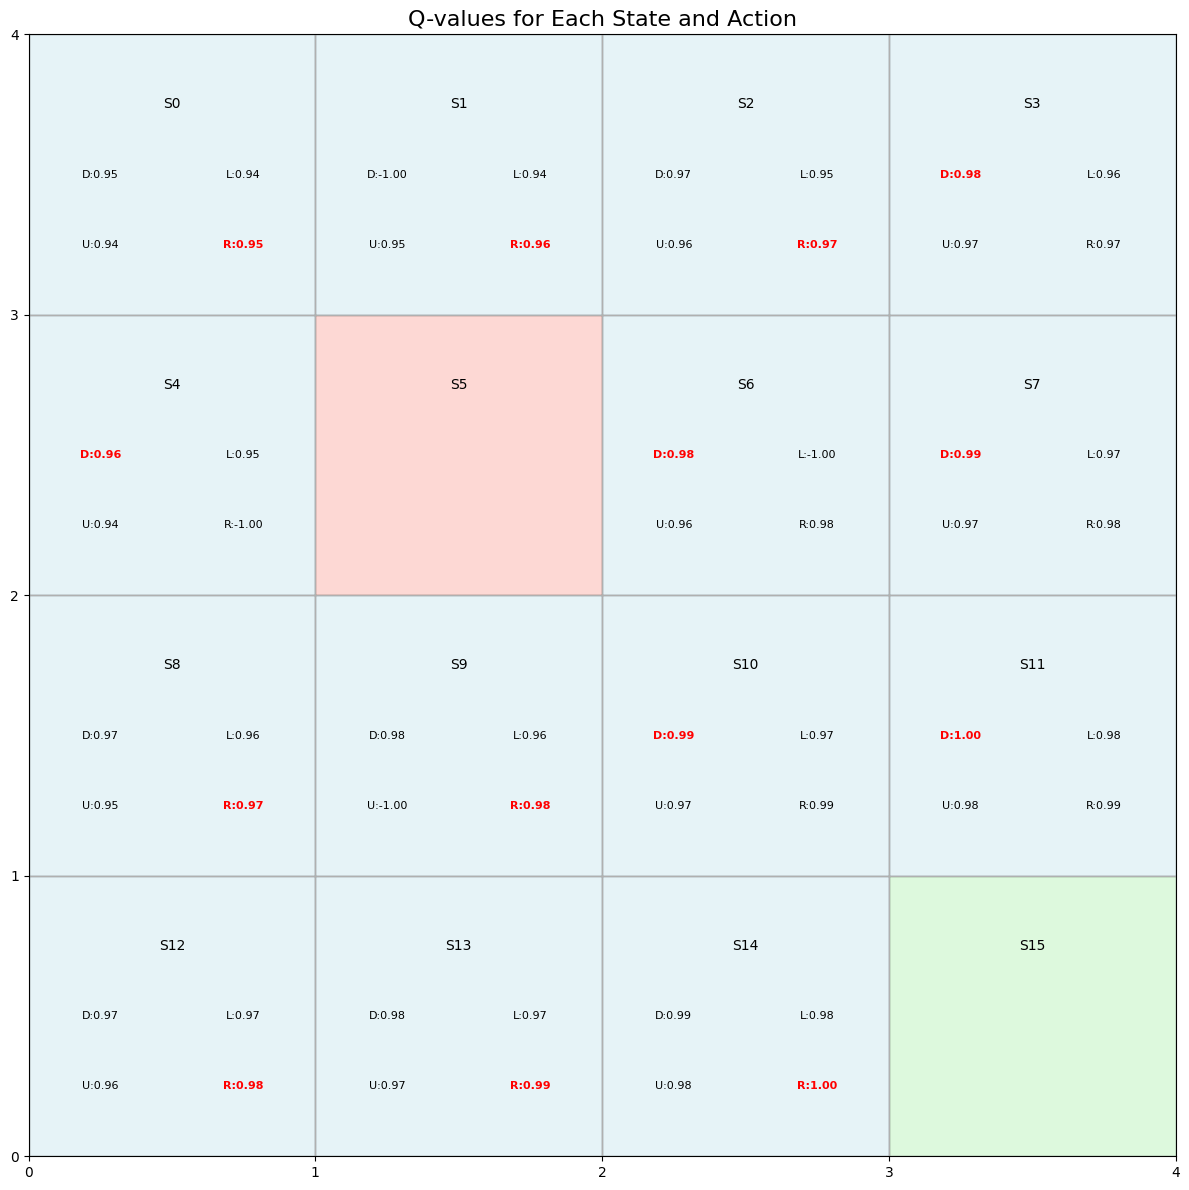

Training agent...


  0%|          | 0/1000 [00:00<?, ?it/s]


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import copy
import seaborn as sns
from tqdm import tqdm

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define the GridWorld environment
class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.action_space = 4  # Up, Right, Down, Left
        self.observation_space = size * size
        self.reset()
        
        # Define rewards
        self.rewards = np.zeros((size, size))
        self.rewards[3, 3] = 1.0    # Goal state
        self.rewards[1, 1] = -1.0   # Penalty state
        
    def reset(self):
        while True:
            self.agent_pos = np.array([random.randint(0, self.size-1), random.randint(0, self.size-1)])
            if not ((self.agent_pos[0] == 3 and self.agent_pos[1] == 3) or 
                    (self.agent_pos[0] == 1 and self.agent_pos[1] == 1)):
                break
        return self._get_state()
    
    def _get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]
    
    def step(self, action):
        directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        new_pos = self.agent_pos + np.array(directions[action])
        
        if 0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size:
            self.agent_pos = new_pos
        
        state = self._get_state()
        done = (self.agent_pos[0] == 3 and self.agent_pos[1] == 3) or (self.agent_pos[0] == 1 and self.agent_pos[1] == 1)
        reward = self.rewards[self.agent_pos[0], self.agent_pos[1]]
        
        return state, reward, done
    
    def get_state_pos(self, state):
        return (state // self.size, state % self.size)

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Memory
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# Agent class with corrected state handling
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=64, gamma=0.99, 
                 eps_start=1.0, eps_end=0.01, eps_decay=0.995, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        
        self.policy_net = DQN(state_size, action_size)
        self.target_net = copy.deepcopy(self.policy_net)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        self.q_values_history = []
        self.loss_history = []
        self.reward_history = []
        
    def select_action(self, state, eval_mode=False):
        if eval_mode or random.random() > self.epsilon:
            with torch.no_grad():
                # One-hot encoding
                state_tensor = torch.zeros(1, self.state_size)
                state_tensor[0, state] = 1
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.action_size)
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        experiences = self.memory.sample(self.batch_size)
        batch = Experience(*zip(*experiences))
        
        # Convert to one-hot encoding
        state_batch = torch.zeros(len(batch.state), self.state_size)
        for i, s in enumerate(batch.state):
            state_batch[i, s] = 1
            
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float)
        
        next_state_batch = torch.zeros(len(batch.next_state), self.state_size)
        for i, s in enumerate(batch.next_state):
            next_state_batch[i, s] = 1
            
        done_batch = torch.tensor(batch.done, dtype=torch.float)
        
        # Compute Q values
        current_q = self.policy_net(state_batch).gather(1, action_batch)
        
        with torch.no_grad():
            next_q = self.target_net(next_state_batch).max(1)[0]
            
        target_q = reward_batch + (1 - done_batch) * self.gamma * next_q
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q.squeeze(), target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        self.loss_history.append(loss.item())
        
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    def update_epsilon(self):
        self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)
        
    def get_q_values(self, env):
        q_values = np.zeros((env.observation_space, self.action_size))
        with torch.no_grad():
            for state in range(env.observation_space):
                state_tensor = torch.zeros(1, self.state_size)
                state_tensor[0, state] = 1
                q_values[state] = self.policy_net(state_tensor).numpy()
        return q_values

# Training function and visualization functions remain the same as original
# [Include all the visualization functions from the original code here]

def run_dqn_gridworld_training():
    env = GridWorld(size=4)
    agent = DQNAgent(state_size=env.observation_space, action_size=env.action_space)
    
    num_episodes = 500
    update_target_every = 10
    snapshot_episodes = list(range(0, num_episodes, update_target_every))
    
    print("Training agent...")
    rewards, q_values_snapshots = train_dqn(agent, env, num_episodes, update_target_every)
    
    print("\nTraining results:")
    plot_training_progress(agent)
    
    print("\nQ-values evolution:")
    visualize_q_values_evolution(env, q_values_snapshots, snapshot_episodes)
    
    final_q_values = agent.get_q_values(env)
    
    print("\nFinal Q-values:")
    visualize_q_values(env, final_q_values)
    
    print("\nOptimal policy:")
    visualize_policy(env, final_q_values)
    
    return agent, env, final_q_values

# Run the training
agent, env, final_q_values = run_dqn_gridworld_training()

# Visualization functions
def plot_training_progress(agent):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Loss plot
    ax1.plot(agent.loss_history)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    
    # Reward plot
    rewards = np.array(agent.reward_history)
    ax2.plot(rewards)
    ax2.set_title('Episode Reward')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    
    plt.tight_layout()
    plt.show()

def visualize_q_values(env, q_values):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    action_names = ['Up', 'Right', 'Down', 'Left']
    
    for action in range(4):
        ax = axs[action // 2, action % 2]
        q_map = np.zeros((env.size, env.size))
        
        for state in range(env.observation_space):
            row, col = env.get_state_pos(state)
            q_map[row, col] = q_values[state, action]
            
        sns.heatmap(q_map, annot=True, cmap='viridis', ax=ax, fmt='.2f')
        ax.set_title(f'Q-values for {action_names[action]}')
        
    plt.tight_layout()
    plt.show()

def visualize_policy(env, q_values):
    policy = np.argmax(q_values, axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define colors and action directions
    action_directions = {
        0: (0, 0.3),   # Up
        1: (0.3, 0),   # Right
        2: (0, -0.3),  # Down
        3: (-0.3, 0)   # Left
    }
    
    # Draw grid
    for i in range(env.size):
        for j in range(env.size):
            state = i * env.size + j
            
            # Determine cell color based on state type
            if i == 3 and j == 3:  # Goal state
                color = 'lightgreen'
            elif i == 1 and j == 1:  # Penalty state
                color = 'salmon'
            else:
                color = 'lightblue'
            
            # Create rectangle for grid cell
            rect = plt.Rectangle((j, env.size - i - 1), 1, 1, 
                                linewidth=1, edgecolor='k', 
                                facecolor=color, alpha=0.3)
            ax.add_patch(rect)
            
            # Add state label
            ax.text(j + 0.5, env.size - i - 0.5, f'S{state}', 
                    ha='center', va='center', fontsize=12)
            
            # Add reward text for terminal states
            if (i == 3 and j == 3) or (i == 1 and j == 1):
                reward = env.rewards[i, j]
                ax.text(j + 0.5, env.size - i - 0.8, f'R={reward}', 
                        ha='center', va='center', fontsize=10)
            
            # Draw arrow for optimal policy (except at terminal states)
            if not ((i == 3 and j == 3) or (i == 1 and j == 1)):
                action = policy[state]
                dx, dy = action_directions[action]
                
                ax.arrow(j + 0.5, env.size - i - 0.5, dx, dy, 
                        head_width=0.1, head_length=0.1, 
                        fc='red', ec='red')
    
    # Set axis properties
    ax.grid(True)
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.set_xticks(np.arange(env.size + 1))
    ax.set_yticks(np.arange(env.size + 1))
    ax.set_title('Optimal Policy', fontsize=16)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', alpha=0.3, edgecolor='k', label='Goal (+1)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='salmon', alpha=0.3, edgecolor='k', label='Penalty (-1)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', alpha=0.3, edgecolor='k', label='Normal State'),
        Line2D([0], [0], marker='>', color='red', markersize=10, label='Optimal Action', linestyle='')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    plt.tight_layout()
    plt.show()
    
    # Create a separate visualization for Q-values in each state
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Draw grid with Q-values
    for i in range(env.size):
        for j in range(env.size):
            state = i * env.size + j
            
            # Determine cell color based on state type
            if i == 3 and j == 3:  # Goal state
                color = 'lightgreen'
            elif i == 1 and j == 1:  # Penalty state
                color = 'salmon'
            else:
                color = 'lightblue'
            
            # Create rectangle for grid cell
            rect = plt.Rectangle((j, env.size - i - 1), 1, 1, 
                                linewidth=1, edgecolor='k', 
                                facecolor=color, alpha=0.3)
            ax.add_patch(rect)
            
            # Add state label
            ax.text(j + 0.5, env.size - i - 0.25, f'S{state}', 
                    ha='center', va='center', fontsize=10)
            
            # Add Q-values for each action
            if not ((i == 3 and j == 3) or (i == 1 and j == 1)):
                action_labels = ['U', 'R', 'D', 'L']
                q_vals = q_values[state]
                best_action = np.argmax(q_vals)
                
                for a, label in enumerate(action_labels):
                    # Position Q-values in four corners of the cell
                    x_offset = 0.25 if a % 2 == 0 else 0.75
                    y_offset = 0.75 if a < 2 else 0.5
                    
                    # Highlight best action
                    weight = 'bold' if a == best_action else 'normal'
                    color = 'red' if a == best_action else 'black'
                    
                    ax.text(j + x_offset, env.size - i - y_offset, 
                            f'{label}:{q_vals[a]:.2f}', 
                            ha='center', va='center', fontsize=8,
                            weight=weight, color=color)
    
    # Set axis properties
    ax.grid(True)
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.set_xticks(np.arange(env.size + 1))
    ax.set_yticks(np.arange(env.size + 1))
    ax.set_title('Q-values for Each State and Action', fontsize=16)
    
    plt.tight_layout()
    plt.show()

def visualize_q_values_evolution(env, q_values_snapshots, snapshot_episodes, num_snapshots=4):
    episodes_to_show = np.linspace(0, len(snapshot_episodes)-1, num_snapshots, dtype=int)
    
    for idx in episodes_to_show:
        episode = snapshot_episodes[idx]
        q_values = q_values_snapshots[idx]
        print(f"Q-values after episode {episode}")
        visualize_q_values(env, q_values)

def run_dqn_gridworld_training():
    # Initialize environment and agent
    env = GridWorld(size=4)
    agent = DQNAgent(state_size=1, action_size=env.action_space)
    
    # Train
    num_episodes = 1000
    update_target_every = 10
    snapshot_episodes = list(range(0, num_episodes, update_target_every))
    
    print("Training agent...")
    rewards, q_values_snapshots = train_dqn(agent, env, num_episodes, update_target_every)
    
    # Visualization
    print("Training completed. Showing results:")
    plot_training_progress(agent)
    
    # Visualize Q-values evolution
    print("Q-values evolution:")
    visualize_q_values_evolution(env, q_values_snapshots, snapshot_episodes)
    
    # Get final Q-values and visualize
    final_q_values = agent.get_q_values(env)
    
    print("Final Q-values for each action:")
    visualize_q_values(env, final_q_values)
    
    print("Optimal policy:")
    visualize_policy(env, final_q_values)
    
    return agent, env, final_q_values

agent, env, final_q_values = run_dqn_gridworld_training()